In [1]:
news_path="../data/with_local_paths/ht_with_local_images.json"

In [2]:
from transformers import BlipProcessor, BlipForConditionalGeneration, pipeline
from PIL import Image
from ultralytics import YOLO
import pandas as pd
import json


/mnt/raid1/MSCs/AY2425/skaul/miniconda3/envs/scraper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/mnt/raid1/MSCs/AY2425/skaul/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
# 3. Load JSON, assign IDs, and retain URL
import json

with open(news_path, "r", encoding="utf-8") as f:
    raw_articles = json.load(f)

articles = []
for idx, art in enumerate(raw_articles):
    imgs = art.get("local_images", [])
    caps = art.get("captions", [])
    if not imgs:
        continue  # skip if no local image
    articles.append({
        "id": idx,
        "title": art.get("title", ""),
        "url": art.get("url", ""),
        "local_images": imgs,
        "captions": caps
    })

# Now each entry has: id, title, url, local_images, captions


In [16]:
# BLIP captioning
processor      = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model  = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
# YOLO object detector
yolo_model     = YOLO("yolov8n.pt")
# Sentiment analyzer
sentiment_analyzer = pipeline("sentiment-analysis")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


100%|██████████| 6.25M/6.25M [00:00<00:00, 9.04MB/s]
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cuda:0


In [29]:
import torch

# 1. Define your device string
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 2. Load YOLO without a device arg
yolo_model = YOLO("yolov8n.pt")

# 3. Make sure your caption model is on GPU
caption_model = caption_model.to(device)

def generate_caption(img: Image.Image) -> str:
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = caption_model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

from collections import Counter

def detect_objects(img: Image.Image) -> dict:
    # run YOLO on the correct device
    res = yolo_model(img, device=device)[0]

    # if no boxes detected, return empty
    if res.boxes is None or len(res.boxes.cls) == 0:
        return {}

    # get class IDs as a CPU numpy array
    cls_ids = res.boxes.cls.cpu().numpy().astype(int)

    # map IDs to names
    labels = [res.names[i] for i in cls_ids]

    # count occurrences
    return dict(Counter(labels))




In [32]:
from tqdm import tqdm

records = []
for art in tqdm(articles[:1000], desc="Processing first 1000 articles"):
    imgs = art.get("local_images", [])
    if not imgs:
        continue

    img_path = imgs[0]
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"⚠️  Skipping {img_path}: {e}")
        continue

    orig_caption = art.get("captions", [""])[0]

    try:
        gen_caption = generate_caption(img)
        objs        = detect_objects(img)               # <- no device arg
        sent_orig   = sentiment_analyzer(orig_caption)[0]
        sent_gen    = sentiment_analyzer(gen_caption)[0]
    except Exception as e:
        print(f"⚠️  Error processing {art['id']} – {e}")
        continue

    records.append({
        "id":             art["id"],
        "title":          art["title"],
        "url":            art.get("url", ""),
        "orig_caption":   orig_caption,
        "gen_caption":    gen_caption,
        "orig_sentiment": sent_orig,
        "gen_sentiment":  sent_gen,
        "object_counts":  objs
    })


Processing first 1000 articles:   0%|          | 0/1000 [00:00<?, ?it/s]


0: 384x640 10 persons, 1 tie, 1 laptop, 4.9ms
Speed: 2.7ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 1/1000 [00:00<06:41,  2.49it/s]


0: 384x640 1 person, 2 cars, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 2/1000 [00:00<04:59,  3.34it/s]


0: 384x640 1 bed, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 3/1000 [00:00<04:55,  3.37it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 4/1000 [00:01<04:25,  3.75it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 5/1000 [00:01<04:42,  3.52it/s]


0: 384x640 7 persons, 2 ties, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 6/1000 [00:01<04:28,  3.70it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 7/1000 [00:02<04:42,  3.51it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 8/1000 [00:02<04:59,  3.31it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 9/1000 [00:02<05:10,  3.19it/s]


0: 384x640 1 airplane, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 10/1000 [00:02<04:42,  3.51it/s]


0: 384x640 2 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 11/1000 [00:03<04:59,  3.31it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 12/1000 [00:03<05:02,  3.26it/s]


0: 384x640 28 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|▏         | 13/1000 [00:03<04:50,  3.39it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|▏         | 14/1000 [00:04<04:42,  3.49it/s]


0: 384x640 5 persons, 2 cars, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 15/1000 [00:04<04:09,  3.95it/s]


0: 384x640 1 person, 1 umbrella, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 16/1000 [00:04<04:34,  3.58it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 17/1000 [00:04<04:44,  3.45it/s]


0: 384x640 7 persons, 1 truck, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 18/1000 [00:05<04:59,  3.28it/s]


0: 384x640 3 persons, 1 book, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 19/1000 [00:05<04:55,  3.32it/s]


0: 384x640 5 persons, 1 truck, 1 frisbee, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 20/1000 [00:05<05:13,  3.13it/s]


0: 384x640 3 persons, 1 boat, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 21/1000 [00:06<04:36,  3.54it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 22/1000 [00:06<04:24,  3.69it/s]


0: 384x640 13 persons, 2 cell phones, 1 book, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 23/1000 [00:06<04:39,  3.50it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 24/1000 [00:07<04:47,  3.39it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▎         | 25/1000 [00:07<05:56,  2.73it/s]


0: 384x640 1 person, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 26/1000 [00:07<05:34,  2.91it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 27/1000 [00:08<05:32,  2.93it/s]


0: 384x640 5 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 28/1000 [00:08<05:10,  3.13it/s]


0: 384x640 6 persons, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 29/1000 [00:08<04:55,  3.29it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 30/1000 [00:09<04:58,  3.25it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 31/1000 [00:09<05:00,  3.23it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 32/1000 [00:09<04:32,  3.55it/s]


0: 384x640 1 boat, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 33/1000 [00:09<04:07,  3.91it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 34/1000 [00:10<04:10,  3.85it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▎         | 35/1000 [00:10<03:44,  4.30it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▎         | 36/1000 [00:10<04:22,  3.67it/s]


0: 384x640 1 traffic light, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▎         | 37/1000 [00:10<04:07,  3.89it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 38/1000 [00:11<04:10,  3.85it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 39/1000 [00:11<04:04,  3.93it/s]


0: 384x640 1 person, 1 tie, 1 sports ball, 1 cup, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 40/1000 [00:11<04:08,  3.87it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 41/1000 [00:11<04:09,  3.84it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 42/1000 [00:12<04:45,  3.35it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 43/1000 [00:12<04:43,  3.38it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 44/1000 [00:13<05:48,  2.74it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 45/1000 [00:13<05:26,  2.92it/s]


0: 384x640 1 person, 1 cup, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 46/1000 [00:13<05:18,  2.99it/s]


0: 384x640 5 persons, 1 tie, 1 cake, 1 chair, 1 dining table, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 47/1000 [00:13<05:13,  3.04it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 48/1000 [00:14<05:14,  3.03it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 49/1000 [00:14<05:08,  3.08it/s]


0: 384x640 6 persons, 4.6ms
Speed: 1.3ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 50/1000 [00:14<05:25,  2.92it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 51/1000 [00:15<05:10,  3.05it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 52/1000 [00:15<05:20,  2.96it/s]


0: 384x640 10 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 53/1000 [00:15<05:19,  2.96it/s]


0: 384x640 5 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 54/1000 [00:16<05:05,  3.10it/s]


0: 384x640 14 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 55/1000 [00:16<05:09,  3.05it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 56/1000 [00:16<05:11,  3.03it/s]


0: 384x640 13 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 57/1000 [00:17<05:00,  3.14it/s]


0: 384x640 5 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 58/1000 [00:17<04:38,  3.38it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 59/1000 [00:17<04:30,  3.48it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 60/1000 [00:18<04:44,  3.30it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 61/1000 [00:18<04:14,  3.69it/s]


0: 384x640 4 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 62/1000 [00:18<03:59,  3.91it/s]


0: 384x640 7 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▋         | 63/1000 [00:18<04:29,  3.48it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▋         | 64/1000 [00:19<04:28,  3.48it/s]


0: 384x640 7 persons, 1 surfboard, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▋         | 65/1000 [00:19<04:37,  3.36it/s]


0: 384x640 2 persons, 3 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 66/1000 [00:19<04:49,  3.23it/s]


0: 384x640 3 persons, 2 ties, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 67/1000 [00:20<04:36,  3.37it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 68/1000 [00:20<04:42,  3.30it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 69/1000 [00:20<04:38,  3.34it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 70/1000 [00:20<04:22,  3.55it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 71/1000 [00:21<04:17,  3.61it/s]


0: 384x640 1 person, 1 tie, 2 wine glasss, 2 cups, 1 cake, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 72/1000 [00:21<04:48,  3.22it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 73/1000 [00:21<05:08,  3.00it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 74/1000 [00:22<04:30,  3.43it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 75/1000 [00:22<04:42,  3.27it/s]


0: 384x640 2 persons, 1 umbrella, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 76/1000 [00:22<04:52,  3.16it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 77/1000 [00:23<04:38,  3.31it/s]


0: 384x640 1 car, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 78/1000 [00:23<04:38,  3.31it/s]


0: 384x640 9 persons, 1 handbag, 1 kite, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 79/1000 [00:23<04:30,  3.41it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 80/1000 [00:23<04:09,  3.68it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 81/1000 [00:24<04:27,  3.44it/s]


0: 384x640 2 persons, 1 car, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 82/1000 [00:24<04:43,  3.24it/s]


0: 384x640 3 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 83/1000 [00:24<04:23,  3.48it/s]


0: 384x640 6 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 84/1000 [00:24<03:55,  3.89it/s]


0: 384x640 11 persons, 1 handbag, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 85/1000 [00:25<04:00,  3.80it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▊         | 86/1000 [00:25<03:58,  3.84it/s]


0: 384x640 5 persons, 1 tie, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▊         | 87/1000 [00:26<05:18,  2.87it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 88/1000 [00:26<05:06,  2.98it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 89/1000 [00:26<04:50,  3.13it/s]


0: 384x640 10 persons, 2 traffic lights, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 90/1000 [00:26<04:32,  3.34it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 91/1000 [00:27<04:33,  3.32it/s]


0: 384x640 7 persons, 1 surfboard, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 92/1000 [00:27<04:34,  3.31it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 93/1000 [00:27<04:34,  3.30it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 94/1000 [00:28<04:54,  3.08it/s]


0: 384x640 2 persons, 2 ties, 1 bowl, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 95/1000 [00:28<04:14,  3.55it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 96/1000 [00:28<04:34,  3.30it/s]


0: 384x640 19 persons, 1 umbrella, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 97/1000 [00:29<04:40,  3.21it/s]


0: 384x640 11 persons, 2 ties, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 98/1000 [00:29<04:38,  3.23it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 99/1000 [00:29<04:37,  3.25it/s]


0: 384x640 12 persons, 1 tie, 1 bowl, 1 chair, 2 potted plants, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 100/1000 [00:29<04:29,  3.33it/s]


0: 384x640 1 person, 1 tie, 1 surfboard, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 101/1000 [00:30<04:49,  3.11it/s]


0: 384x640 1 person, 4.8ms
Speed: 2.7ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 102/1000 [00:30<04:57,  3.02it/s]


0: 384x640 (no detections), 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 103/1000 [00:30<04:50,  3.09it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 104/1000 [00:31<04:44,  3.15it/s]


0: 384x640 1 person, 1 tie, 1 surfboard, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 105/1000 [00:31<04:51,  3.07it/s]


0: 384x640 12 persons, 1 motorcycle, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 106/1000 [00:31<04:45,  3.13it/s]


0: 384x640 1 person, 1 bench, 1 tie, 1 surfboard, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 107/1000 [00:32<04:17,  3.46it/s]


0: 384x640 1 person, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 108/1000 [00:32<04:58,  2.99it/s]


0: 384x640 5 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 109/1000 [00:32<04:52,  3.05it/s]


0: 384x640 4 persons, 1 car, 1 bus, 1 truck, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 110/1000 [00:33<05:36,  2.65it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 111/1000 [00:33<05:32,  2.67it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 112/1000 [00:34<05:33,  2.66it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█▏        | 113/1000 [00:34<05:30,  2.68it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█▏        | 114/1000 [00:34<05:02,  2.93it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 115/1000 [00:35<04:56,  2.98it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 116/1000 [00:35<05:05,  2.90it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 117/1000 [00:35<05:10,  2.84it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 118/1000 [00:36<04:52,  3.02it/s]


0: 384x640 8 persons, 4 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 119/1000 [00:36<05:02,  2.92it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 120/1000 [00:36<04:42,  3.11it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 121/1000 [00:37<04:34,  3.20it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 122/1000 [00:37<04:26,  3.29it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 123/1000 [00:37<04:52,  3.00it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 124/1000 [00:38<04:38,  3.15it/s]


0: 384x640 6 persons, 1 tie, 2 bottles, 2 couchs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▎        | 125/1000 [00:38<04:41,  3.11it/s]


0: 384x640 3 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 126/1000 [00:38<04:37,  3.14it/s]


0: 384x640 4 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 127/1000 [00:39<04:41,  3.10it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 128/1000 [00:39<04:00,  3.63it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 129/1000 [00:39<03:56,  3.68it/s]


0: 384x640 4 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 130/1000 [00:39<04:05,  3.54it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 131/1000 [00:40<04:11,  3.45it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 132/1000 [00:40<04:17,  3.37it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 133/1000 [00:40<04:20,  3.33it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 134/1000 [00:40<04:07,  3.49it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▎        | 135/1000 [00:41<04:07,  3.50it/s]


0: 384x640 15 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▎        | 136/1000 [00:41<04:27,  3.23it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▎        | 137/1000 [00:41<04:19,  3.33it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 138/1000 [00:42<04:32,  3.17it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 139/1000 [00:42<04:42,  3.05it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 140/1000 [00:42<04:33,  3.14it/s]


0: 384x640 2 persons, 2 ties, 2 chairs, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 141/1000 [00:43<04:07,  3.48it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 142/1000 [00:43<04:11,  3.41it/s]

⚠️  Skipping ../data/images/ht_art148_img1_550x309.jpg: cannot identify image file '../data/images/ht_art148_img1_550x309.jpg'


/mnt/raid1/MSCs/AY2425/skaul/miniconda3/envs/scraper/lib/python3.10/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)



0: 384x640 3 persons, 2 trucks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 144/1000 [00:43<03:08,  4.55it/s]


0: 384x640 7 persons, 1 car, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 145/1000 [00:43<03:31,  4.05it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 146/1000 [00:44<03:42,  3.83it/s]


0: 384x640 5 persons, 3 cars, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 147/1000 [00:44<03:51,  3.68it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 148/1000 [00:45<04:32,  3.13it/s]


0: 384x640 1 person, 4 cars, 1 bus, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 149/1000 [00:45<04:33,  3.11it/s]


0: 384x640 2 persons, 1 refrigerator, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 150/1000 [00:45<04:50,  2.93it/s]


0: 384x640 2 persons, 1 car, 1 truck, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 151/1000 [00:46<04:34,  3.09it/s]


0: 384x640 3 persons, 1 bus, 1 truck, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 152/1000 [00:46<04:12,  3.36it/s]


0: 384x640 2 persons, 2 cars, 1 traffic light, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 153/1000 [00:46<04:12,  3.35it/s]


0: 384x640 1 person, 1 cat, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 154/1000 [00:46<04:18,  3.27it/s]


0: 384x640 5 persons, 6.7ms
Speed: 3.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 155/1000 [00:47<04:18,  3.27it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 156/1000 [00:47<04:19,  3.25it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 157/1000 [00:47<04:24,  3.19it/s]


0: 384x640 13 persons, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 158/1000 [00:48<05:20,  2.62it/s]


0: 384x640 2 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 159/1000 [00:48<05:03,  2.77it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 160/1000 [00:48<04:49,  2.90it/s]


0: 384x640 17 persons, 1 truck, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 161/1000 [00:49<04:39,  3.00it/s]


0: 384x640 1 clock, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 162/1000 [00:49<04:15,  3.28it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▋        | 163/1000 [00:49<04:04,  3.43it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▋        | 164/1000 [00:50<04:02,  3.44it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▋        | 165/1000 [00:50<04:00,  3.48it/s]


0: 384x640 2 persons, 1 car, 1 bus, 1 truck, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 166/1000 [00:50<03:48,  3.66it/s]


0: 384x640 2 persons, 1 car, 1 bus, 1 traffic light, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 167/1000 [00:50<03:35,  3.86it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 168/1000 [00:51<03:50,  3.62it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 169/1000 [00:51<04:08,  3.35it/s]


0: 384x640 14 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 170/1000 [00:51<04:03,  3.41it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 171/1000 [00:52<03:54,  3.54it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 172/1000 [00:52<04:35,  3.01it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 173/1000 [00:52<04:22,  3.15it/s]


0: 384x640 8 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 174/1000 [00:53<04:14,  3.25it/s]


0: 384x640 9 persons, 2 backpacks, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 175/1000 [00:53<03:59,  3.44it/s]


0: 384x640 10 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 176/1000 [00:53<04:22,  3.14it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 177/1000 [00:54<04:30,  3.04it/s]


0: 384x640 5 persons, 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 178/1000 [00:54<04:32,  3.02it/s]


0: 384x640 1 person, 1 dog, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 179/1000 [00:54<04:21,  3.14it/s]


0: 384x640 1 person, 3 cars, 1 tie, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 180/1000 [00:54<04:17,  3.18it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 181/1000 [00:55<04:27,  3.06it/s]


0: 384x640 9 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 182/1000 [00:55<04:17,  3.18it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 183/1000 [00:55<04:14,  3.21it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 184/1000 [00:56<04:29,  3.03it/s]


0: 384x640 1 person, 1 umbrella, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 185/1000 [00:56<04:07,  3.30it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▊        | 186/1000 [00:56<03:55,  3.46it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▊        | 187/1000 [00:57<03:55,  3.46it/s]


0: 384x640 7 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 188/1000 [00:57<04:12,  3.21it/s]


0: 384x640 2 persons, 1 handbag, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 189/1000 [00:57<04:07,  3.28it/s]


0: 384x640 11 persons, 6.3ms
Speed: 2.9ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 190/1000 [00:58<04:15,  3.16it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 191/1000 [00:58<04:08,  3.25it/s]


0: 384x640 1 person, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 192/1000 [00:58<04:27,  3.02it/s]


0: 384x640 3 persons, 1 tie, 1 laptop, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 193/1000 [00:59<04:21,  3.08it/s]


0: 384x640 5 persons, 1 boat, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 194/1000 [00:59<04:41,  2.86it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 195/1000 [00:59<04:27,  3.01it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 196/1000 [01:00<04:22,  3.06it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 197/1000 [01:00<04:12,  3.18it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 198/1000 [01:00<04:11,  3.19it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 2.7ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 199/1000 [01:00<04:09,  3.21it/s]


0: 384x640 6 persons, 1 truck, 1 backpack, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 200/1000 [01:01<04:02,  3.30it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 201/1000 [01:01<04:01,  3.31it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 202/1000 [01:01<03:50,  3.47it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 203/1000 [01:02<03:48,  3.50it/s]


0: 384x640 4 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 204/1000 [01:02<03:52,  3.42it/s]


0: 384x640 12 persons, 2 cups, 1 laptop, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 205/1000 [01:02<04:19,  3.06it/s]


0: 384x640 3 persons, 1 chair, 1 potted plant, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 206/1000 [01:03<04:11,  3.16it/s]


0: 384x640 16 persons, 1 tie, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 207/1000 [01:03<04:26,  2.98it/s]


0: 384x640 11 persons, 1 truck, 1 traffic light, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 208/1000 [01:03<04:31,  2.92it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 209/1000 [01:04<04:11,  3.14it/s]


0: 384x640 2 persons, 1 tie, 1 surfboard, 1 chair, 1 couch, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 210/1000 [01:04<03:52,  3.39it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 211/1000 [01:04<03:56,  3.33it/s]


0: 384x640 6 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 212/1000 [01:04<04:03,  3.23it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██▏       | 213/1000 [01:05<04:12,  3.11it/s]


0: 384x640 11 persons, 2 cars, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██▏       | 214/1000 [01:05<03:40,  3.56it/s]


0: 384x640 8 persons, 4 ties, 2 chairs, 1 tv, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 215/1000 [01:05<03:56,  3.32it/s]


0: 384x640 4 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 216/1000 [01:06<03:35,  3.64it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 217/1000 [01:06<03:30,  3.72it/s]


0: 384x640 1 person, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 218/1000 [01:06<03:48,  3.42it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 219/1000 [01:06<03:33,  3.65it/s]


0: 384x640 1 person, 2 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 220/1000 [01:07<03:35,  3.62it/s]


0: 384x640 4 persons, 1 bottle, 2 chairs, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 221/1000 [01:07<03:42,  3.50it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 222/1000 [01:07<04:01,  3.22it/s]


0: 384x640 2 persons, 3 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 223/1000 [01:08<03:42,  3.49it/s]


0: 384x640 11 persons, 3 cars, 1 elephant, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 224/1000 [01:08<03:19,  3.88it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▎       | 225/1000 [01:08<03:30,  3.68it/s]


0: 384x640 17 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 226/1000 [01:08<03:42,  3.48it/s]


0: 384x640 2 persons, 1 bench, 2 backpacks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 227/1000 [01:09<03:40,  3.50it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 228/1000 [01:09<03:45,  3.43it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 229/1000 [01:09<03:47,  3.38it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 230/1000 [01:10<04:00,  3.20it/s]


0: 384x640 4 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 231/1000 [01:10<04:19,  2.97it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 232/1000 [01:10<03:59,  3.21it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 233/1000 [01:11<03:46,  3.39it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 234/1000 [01:11<03:48,  3.35it/s]


0: 384x640 3 persons, 1 car, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▎       | 235/1000 [01:11<04:00,  3.18it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▎       | 236/1000 [01:12<04:03,  3.13it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▎       | 237/1000 [01:12<03:49,  3.32it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 238/1000 [01:12<04:01,  3.16it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 239/1000 [01:12<03:57,  3.21it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 240/1000 [01:13<04:06,  3.08it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 241/1000 [01:13<04:13,  3.00it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 242/1000 [01:14<04:17,  2.94it/s]


0: 384x640 1 person, 2 airplanes, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 243/1000 [01:14<04:23,  2.87it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 244/1000 [01:14<04:30,  2.79it/s]


0: 384x640 1 car, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 245/1000 [01:15<04:24,  2.85it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 246/1000 [01:15<04:25,  2.84it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 247/1000 [01:15<04:25,  2.83it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 248/1000 [01:16<04:03,  3.09it/s]


0: 384x640 1 cake, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 249/1000 [01:16<03:31,  3.56it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 250/1000 [01:16<03:47,  3.30it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 251/1000 [01:16<03:48,  3.28it/s]


0: 384x640 10 persons, 2 traffic lights, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 252/1000 [01:17<03:38,  3.42it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 253/1000 [01:17<03:45,  3.32it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 254/1000 [01:17<03:40,  3.39it/s]


0: 384x640 4 persons, 2 cars, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 255/1000 [01:18<03:36,  3.44it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 256/1000 [01:18<03:29,  3.55it/s]


0: 384x640 1 train, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 257/1000 [01:18<03:15,  3.81it/s]


0: 384x640 11 persons, 2 chairs, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 258/1000 [01:18<03:21,  3.68it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 259/1000 [01:19<03:29,  3.53it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 260/1000 [01:19<03:25,  3.61it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 261/1000 [01:19<03:21,  3.67it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 262/1000 [01:19<03:24,  3.60it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▋       | 263/1000 [01:20<03:26,  3.57it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▋       | 264/1000 [01:20<03:23,  3.62it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▋       | 265/1000 [01:20<03:42,  3.30it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 266/1000 [01:21<03:47,  3.23it/s]


0: 384x640 1 person, 1 tie, 1 clock, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 267/1000 [01:21<03:46,  3.23it/s]


0: 384x640 3 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 268/1000 [01:22<04:38,  2.63it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 269/1000 [01:22<04:48,  2.54it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 270/1000 [01:22<04:39,  2.62it/s]


0: 384x640 4 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 271/1000 [01:23<04:22,  2.78it/s]


0: 384x640 9 persons, 1 frisbee, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 272/1000 [01:23<03:46,  3.22it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 273/1000 [01:23<04:27,  2.72it/s]


0: 384x640 2 persons, 1 tie, 1 chair, 1 couch, 1 laptop, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 274/1000 [01:24<04:09,  2.91it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 275/1000 [01:24<04:06,  2.94it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 276/1000 [01:24<04:04,  2.96it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 277/1000 [01:25<03:41,  3.26it/s]


0: 384x640 3 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 278/1000 [01:25<03:36,  3.33it/s]


0: 384x640 5 persons, 1 car, 2 umbrellas, 2 chairs, 1 vase, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 279/1000 [01:25<03:15,  3.70it/s]


0: 384x640 15 persons, 1 car, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 280/1000 [01:25<03:19,  3.61it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 281/1000 [01:26<03:34,  3.35it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 282/1000 [01:26<03:24,  3.52it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 283/1000 [01:26<03:28,  3.44it/s]


0: 384x640 8 persons, 2 cell phones, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 284/1000 [01:26<03:25,  3.48it/s]


0: 384x640 1 umbrella, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 285/1000 [01:27<03:08,  3.79it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▊       | 286/1000 [01:27<03:47,  3.15it/s]


0: 384x640 7 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▊       | 287/1000 [01:27<03:37,  3.27it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 288/1000 [01:28<03:49,  3.10it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 289/1000 [01:28<03:55,  3.02it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 290/1000 [01:28<03:54,  3.02it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 291/1000 [01:29<03:39,  3.23it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 292/1000 [01:29<03:46,  3.13it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 293/1000 [01:29<03:52,  3.05it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 294/1000 [01:30<03:42,  3.18it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 295/1000 [01:30<03:20,  3.52it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 296/1000 [01:30<03:54,  3.00it/s]


0: 384x640 1 person, 5.6ms
Speed: 2.6ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 297/1000 [01:31<04:19,  2.71it/s]


0: 384x640 1 person, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 298/1000 [01:31<04:27,  2.63it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 299/1000 [01:32<04:05,  2.85it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 300/1000 [01:32<03:45,  3.10it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 301/1000 [01:32<03:52,  3.01it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 302/1000 [01:32<03:35,  3.23it/s]


0: 384x640 1 train, 2 trucks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 303/1000 [01:33<03:35,  3.24it/s]


0: 384x640 2 persons, 1 tie, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 304/1000 [01:33<03:34,  3.24it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 305/1000 [01:33<03:49,  3.03it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 306/1000 [01:34<03:24,  3.40it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 307/1000 [01:34<03:16,  3.54it/s]


0: 384x640 1 person, 1 tie, 1 clock, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 308/1000 [01:34<03:30,  3.28it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 309/1000 [01:34<03:20,  3.44it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 310/1000 [01:35<03:41,  3.11it/s]


0: 384x640 5 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 311/1000 [01:35<03:52,  2.96it/s]


0: 384x640 3 persons, 1 cell phone, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 312/1000 [01:35<03:41,  3.11it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███▏      | 313/1000 [01:36<03:22,  3.39it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███▏      | 314/1000 [01:36<03:14,  3.52it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 315/1000 [01:36<03:13,  3.53it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 316/1000 [01:37<03:17,  3.47it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 317/1000 [01:37<03:20,  3.41it/s]


0: 384x640 2 persons, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 318/1000 [01:37<03:23,  3.36it/s]


0: 384x640 3 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 319/1000 [01:37<03:24,  3.32it/s]


0: 384x640 5 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 320/1000 [01:38<03:20,  3.39it/s]


0: 384x640 1 person, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 321/1000 [01:38<03:08,  3.59it/s]


0: 384x640 1 person, 1 motorcycle, 1 bird, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 322/1000 [01:39<04:02,  2.80it/s]


0: 384x640 5 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 323/1000 [01:39<04:01,  2.80it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 324/1000 [01:39<04:00,  2.81it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▎      | 325/1000 [01:40<04:00,  2.81it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 326/1000 [01:40<03:39,  3.07it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 327/1000 [01:40<03:26,  3.25it/s]


0: 384x640 1 book, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 328/1000 [01:40<02:57,  3.78it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 329/1000 [01:41<03:12,  3.49it/s]


0: 384x640 1 boat, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 330/1000 [01:41<02:51,  3.90it/s]


0: 384x640 1 person, 1 motorcycle, 1 bird, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 331/1000 [01:41<03:10,  3.51it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 332/1000 [01:41<03:03,  3.63it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 333/1000 [01:42<03:04,  3.61it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 334/1000 [01:42<03:47,  2.93it/s]


0: 384x640 3 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▎      | 335/1000 [01:42<03:30,  3.17it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▎      | 336/1000 [01:43<03:18,  3.35it/s]


0: 384x640 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▎      | 337/1000 [01:43<03:14,  3.40it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 338/1000 [01:43<02:53,  3.82it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 339/1000 [01:43<03:01,  3.64it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 340/1000 [01:44<03:21,  3.27it/s]


0: 384x640 4 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 341/1000 [01:44<03:14,  3.38it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 342/1000 [01:44<03:24,  3.21it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 343/1000 [01:45<03:34,  3.07it/s]


0: 384x640 (no detections), 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 344/1000 [01:45<03:44,  2.93it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 345/1000 [01:45<03:22,  3.24it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 346/1000 [01:46<03:17,  3.31it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 347/1000 [01:46<03:36,  3.01it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 348/1000 [01:46<03:22,  3.23it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 349/1000 [01:47<03:30,  3.09it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 350/1000 [01:47<03:30,  3.09it/s]


0: 384x640 2 persons, 2 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 351/1000 [01:48<04:06,  2.64it/s]


0: 384x640 11 persons, 2 backpacks, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 352/1000 [01:48<04:11,  2.58it/s]


0: 384x640 11 airplanes, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 353/1000 [01:48<03:55,  2.75it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 354/1000 [01:49<03:49,  2.82it/s]


0: 384x640 2 persons, 2 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 355/1000 [01:49<03:40,  2.92it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 356/1000 [01:49<03:29,  3.07it/s]


0: 384x640 1 cake, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 357/1000 [01:50<03:35,  2.98it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 358/1000 [01:50<03:25,  3.13it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 359/1000 [01:50<03:13,  3.31it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 360/1000 [01:50<03:04,  3.46it/s]


0: 384x640 2 persons, 1 tie, 2 surfboards, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 361/1000 [01:51<03:17,  3.24it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 362/1000 [01:51<03:10,  3.34it/s]


0: 384x640 4 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▋      | 363/1000 [01:51<02:45,  3.85it/s]


0: 384x640 6 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▋      | 364/1000 [01:51<02:49,  3.74it/s]


0: 384x640 1 person, 3 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▋      | 365/1000 [01:52<02:52,  3.69it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 366/1000 [01:52<03:08,  3.37it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 367/1000 [01:52<03:04,  3.43it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 368/1000 [01:53<02:57,  3.56it/s]


0: 384x640 1 laptop, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 369/1000 [01:53<02:45,  3.80it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 370/1000 [01:53<03:04,  3.41it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 371/1000 [01:54<03:14,  3.23it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 372/1000 [01:54<03:21,  3.12it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 373/1000 [01:54<03:26,  3.04it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 374/1000 [01:55<03:17,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 375/1000 [01:55<03:06,  3.36it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 376/1000 [01:55<03:16,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 377/1000 [01:55<03:05,  3.37it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 378/1000 [01:56<03:06,  3.34it/s]


0: 384x640 7 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 379/1000 [01:56<02:58,  3.48it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 380/1000 [01:56<03:09,  3.27it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 381/1000 [01:57<03:09,  3.27it/s]


0: 384x640 1 person, 1 couch, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 382/1000 [01:57<03:09,  3.26it/s]


0: 384x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 383/1000 [01:57<03:04,  3.35it/s]


0: 384x640 6 persons, 1 car, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 384/1000 [01:58<03:00,  3.41it/s]


0: 384x640 1 person, 1 traffic light, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 385/1000 [01:58<02:49,  3.63it/s]


0: 384x640 14 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▊      | 386/1000 [01:58<02:50,  3.60it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▊      | 387/1000 [01:58<02:59,  3.41it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 388/1000 [01:59<03:06,  3.28it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 389/1000 [01:59<03:11,  3.18it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 390/1000 [01:59<03:10,  3.20it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 391/1000 [02:00<03:20,  3.04it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 392/1000 [02:00<03:07,  3.24it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 393/1000 [02:00<03:21,  3.02it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 394/1000 [02:01<03:28,  2.91it/s]


0: 384x640 1 person, 1 tie, 5.6ms
Speed: 2.7ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 395/1000 [02:01<03:25,  2.94it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 396/1000 [02:01<03:10,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 397/1000 [02:02<03:01,  3.33it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 398/1000 [02:02<02:58,  3.37it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 399/1000 [02:02<03:09,  3.18it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 400/1000 [02:03<03:07,  3.21it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 401/1000 [02:03<03:15,  3.07it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 402/1000 [02:03<03:02,  3.27it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 403/1000 [02:03<02:57,  3.36it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 404/1000 [02:04<02:50,  3.50it/s]


0: 384x640 8 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 405/1000 [02:04<02:36,  3.79it/s]


0: 384x640 8 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 406/1000 [02:04<02:26,  4.05it/s]


0: 384x640 3 persons, 2 ties, 1 chair, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 407/1000 [02:05<02:56,  3.37it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 408/1000 [02:05<03:05,  3.19it/s]


0: 384x640 4 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 409/1000 [02:05<03:07,  3.14it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 410/1000 [02:06<03:04,  3.20it/s]


0: 384x640 5 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 411/1000 [02:06<03:06,  3.15it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 412/1000 [02:06<02:59,  3.27it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████▏     | 413/1000 [02:06<02:59,  3.27it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████▏     | 414/1000 [02:07<02:54,  3.35it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 415/1000 [02:07<02:56,  3.32it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 416/1000 [02:07<03:18,  2.94it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 417/1000 [02:08<03:20,  2.91it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 418/1000 [02:08<03:13,  3.01it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 419/1000 [02:08<02:59,  3.23it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 420/1000 [02:09<03:06,  3.11it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 421/1000 [02:09<02:54,  3.31it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 422/1000 [02:09<02:54,  3.32it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 423/1000 [02:10<02:49,  3.40it/s]


0: 384x640 10 persons, 2 traffic lights, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 424/1000 [02:10<02:44,  3.51it/s]


0: 384x640 2 persons, 1 tie, 1 laptop, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▎     | 425/1000 [02:10<03:31,  2.72it/s]


0: 384x640 12 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 426/1000 [02:11<03:20,  2.86it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 427/1000 [02:11<03:20,  2.85it/s]


0: 384x640 4 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 428/1000 [02:11<02:51,  3.33it/s]


0: 384x640 1 person, 1 wine glass, 1 chair, 1 dining table, 1 tv, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 429/1000 [02:11<02:36,  3.66it/s]


0: 384x640 19 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 430/1000 [02:12<02:36,  3.63it/s]


0: 384x640 24 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 431/1000 [02:12<02:38,  3.59it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 432/1000 [02:12<02:50,  3.33it/s]


0: 384x640 8 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 433/1000 [02:13<02:51,  3.31it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 434/1000 [02:13<03:04,  3.07it/s]


0: 384x640 1 person, 1 tie, 1 cup, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▎     | 435/1000 [02:13<03:04,  3.06it/s]


0: 384x640 13 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▎     | 436/1000 [02:14<02:55,  3.20it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▎     | 437/1000 [02:14<02:54,  3.23it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 438/1000 [02:14<02:53,  3.23it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 439/1000 [02:15<02:59,  3.13it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 440/1000 [02:15<03:01,  3.09it/s]


0: 384x640 1 bus, 1 train, 2 trucks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 441/1000 [02:15<02:50,  3.27it/s]


0: 384x640 7 persons, 1 elephant, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 442/1000 [02:15<02:46,  3.36it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 443/1000 [02:16<02:43,  3.41it/s]


0: 384x640 2 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 444/1000 [02:16<02:54,  3.18it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 445/1000 [02:16<03:01,  3.06it/s]


0: 384x640 13 persons, 3 handbags, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 446/1000 [02:17<03:07,  2.96it/s]


0: 384x640 4 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 447/1000 [02:17<03:01,  3.04it/s]


0: 384x640 14 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 448/1000 [02:18<03:17,  2.80it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 449/1000 [02:18<03:12,  2.86it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 450/1000 [02:18<03:09,  2.90it/s]


0: 384x640 1 cake, 1 clock, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 451/1000 [02:18<02:43,  3.36it/s]


0: 384x640 4 persons, 3 ties, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 452/1000 [02:19<02:52,  3.18it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 453/1000 [02:19<02:43,  3.35it/s]


0: 384x640 8 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 454/1000 [02:19<02:25,  3.75it/s]


0: 384x640 2 persons, 1 frisbee, 1 laptop, 1 clock, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 455/1000 [02:20<02:32,  3.57it/s]


0: 384x640 1 person, 1 suitcase, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 456/1000 [02:20<02:43,  3.33it/s]


0: 384x640 1 person, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 457/1000 [02:20<03:23,  2.67it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 458/1000 [02:21<03:26,  2.62it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 459/1000 [02:21<03:33,  2.54it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 460/1000 [02:21<03:03,  2.94it/s]


0: 384x640 1 person, 1 potted plant, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 461/1000 [02:22<02:38,  3.39it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 462/1000 [02:22<02:48,  3.20it/s]


0: 384x640 5 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▋     | 463/1000 [02:22<02:47,  3.20it/s]


0: 384x640 15 persons, 2 ties, 1 chair, 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▋     | 464/1000 [02:23<02:47,  3.21it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▋     | 465/1000 [02:23<03:24,  2.61it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 466/1000 [02:23<02:52,  3.09it/s]


0: 384x640 10 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 467/1000 [02:24<02:49,  3.14it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 468/1000 [02:24<03:15,  2.72it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 469/1000 [02:24<03:05,  2.86it/s]


0: 384x640 1 person, 1 tie, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 470/1000 [02:25<03:14,  2.73it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 471/1000 [02:25<02:52,  3.06it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 472/1000 [02:25<02:48,  3.13it/s]


0: 384x640 1 clock, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 473/1000 [02:26<02:42,  3.25it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 474/1000 [02:26<02:30,  3.50it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 475/1000 [02:26<02:40,  3.27it/s]


0: 384x640 6 persons, 1 suitcase, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 476/1000 [02:27<02:44,  3.19it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 477/1000 [02:27<02:50,  3.06it/s]


0: 384x640 2 persons, 1 bed, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 478/1000 [02:27<02:37,  3.32it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 479/1000 [02:28<03:14,  2.67it/s]


0: 384x640 12 persons, 2 backpacks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 480/1000 [02:28<03:33,  2.44it/s]


0: 384x640 9 persons, 3 ties, 1 dining table, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 481/1000 [02:29<03:13,  2.68it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 482/1000 [02:29<03:20,  2.58it/s]


0: 384x640 3 persons, 2 trucks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 483/1000 [02:29<02:52,  2.99it/s]


0: 384x640 2 persons, 1 train, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 484/1000 [02:29<02:48,  3.06it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 485/1000 [02:30<02:52,  2.99it/s]


0: 384x640 6 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▊     | 486/1000 [02:30<02:59,  2.87it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▊     | 487/1000 [02:31<03:19,  2.57it/s]


0: 384x640 1 person, 1 bus, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 488/1000 [02:31<03:01,  2.81it/s]


0: 384x640 2 persons, 2 chairs, 5.0ms
Speed: 2.6ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 489/1000 [02:31<02:43,  3.12it/s]


0: 384x640 14 persons, 3 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 490/1000 [02:32<02:44,  3.10it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 491/1000 [02:32<02:23,  3.54it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 492/1000 [02:32<02:09,  3.93it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 493/1000 [02:32<02:25,  3.48it/s]


0: 384x640 16 persons, 5 backpacks, 5 suitcases, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 494/1000 [02:33<02:25,  3.47it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 495/1000 [02:33<02:25,  3.47it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 496/1000 [02:33<03:04,  2.74it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 497/1000 [02:34<02:54,  2.89it/s]


0: 384x640 8 persons, 4 ties, 2 surfboards, 1 cup, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 498/1000 [02:34<02:44,  3.05it/s]


0: 384x640 7 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 499/1000 [02:34<02:43,  3.06it/s]


0: 384x640 3 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 500/1000 [02:35<02:29,  3.34it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 501/1000 [02:35<02:49,  2.95it/s]


0: 384x640 2 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 502/1000 [02:35<02:50,  2.92it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 503/1000 [02:36<02:44,  3.02it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 504/1000 [02:36<02:43,  3.03it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 505/1000 [02:36<02:36,  3.17it/s]


0: 384x640 15 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 506/1000 [02:36<02:23,  3.44it/s]


0: 384x640 15 persons, 1 car, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 507/1000 [02:37<02:30,  3.28it/s]


0: 384x640 8 persons, 2 cell phones, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 508/1000 [02:37<02:34,  3.19it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 509/1000 [02:37<02:38,  3.09it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 510/1000 [02:38<02:32,  3.21it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 511/1000 [02:38<02:24,  3.38it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 512/1000 [02:38<02:22,  3.43it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████▏    | 513/1000 [02:39<02:16,  3.57it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████▏    | 514/1000 [02:39<02:30,  3.23it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 515/1000 [02:39<02:22,  3.40it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 516/1000 [02:39<02:23,  3.37it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 517/1000 [02:40<02:04,  3.89it/s]


0: 384x640 5 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 518/1000 [02:40<02:14,  3.59it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 519/1000 [02:40<02:14,  3.57it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 520/1000 [02:41<02:15,  3.55it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 521/1000 [02:41<02:41,  2.96it/s]


0: 384x640 2 persons, 2 umbrellas, 3 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 522/1000 [02:41<02:40,  2.99it/s]


0: 384x640 3 persons, 3 cars, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 523/1000 [02:42<02:21,  3.37it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 524/1000 [02:42<02:30,  3.17it/s]


0: 384x640 8 persons, 1 skateboard, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▎    | 525/1000 [02:42<02:11,  3.62it/s]


0: 384x640 4 persons, 1 tie, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 526/1000 [02:42<02:24,  3.27it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 527/1000 [02:43<02:17,  3.44it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 528/1000 [02:43<02:25,  3.23it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 529/1000 [02:43<02:21,  3.33it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 530/1000 [02:44<02:55,  2.68it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 531/1000 [02:44<02:45,  2.84it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 532/1000 [02:44<02:32,  3.07it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 533/1000 [02:45<02:26,  3.18it/s]


0: 384x640 1 person, 3 trucks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 534/1000 [02:45<02:32,  3.06it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▎    | 535/1000 [02:45<02:21,  3.28it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▎    | 536/1000 [02:46<02:06,  3.67it/s]


0: 384x640 9 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▎    | 537/1000 [02:46<02:00,  3.84it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 538/1000 [02:46<01:53,  4.07it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 539/1000 [02:46<01:54,  4.02it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 540/1000 [02:47<02:02,  3.74it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 541/1000 [02:47<02:08,  3.58it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 542/1000 [02:47<02:12,  3.47it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 543/1000 [02:48<02:17,  3.34it/s]


0: 384x640 3 persons, 1 tie, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 544/1000 [02:48<02:21,  3.23it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 545/1000 [02:48<02:27,  3.09it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 546/1000 [02:49<02:31,  3.00it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 547/1000 [02:49<02:28,  3.06it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 548/1000 [02:49<02:18,  3.26it/s]


0: 384x640 1 person, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 549/1000 [02:50<02:29,  3.02it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 550/1000 [02:50<02:22,  3.15it/s]


0: 384x640 1 person, 1 tie, 3 books, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 551/1000 [02:50<02:27,  3.05it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 552/1000 [02:51<02:48,  2.65it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 553/1000 [02:51<03:04,  2.43it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 554/1000 [02:51<02:46,  2.68it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 555/1000 [02:52<02:30,  2.95it/s]


0: 384x640 1 person, 1 truck, 1 boat, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 556/1000 [02:52<02:29,  2.97it/s]


0: 384x640 2 persons, 2 ties, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 557/1000 [02:52<02:27,  3.00it/s]


0: 384x640 1 person, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 558/1000 [02:53<02:26,  3.01it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 559/1000 [02:53<02:29,  2.96it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 560/1000 [02:53<02:21,  3.11it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 561/1000 [02:54<02:12,  3.31it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 562/1000 [02:54<02:06,  3.46it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▋    | 563/1000 [02:54<02:06,  3.47it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▋    | 564/1000 [02:54<02:07,  3.41it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▋    | 565/1000 [02:55<02:15,  3.22it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 566/1000 [02:55<02:08,  3.38it/s]


0: 384x640 8 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 567/1000 [02:55<02:19,  3.10it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 568/1000 [02:56<02:23,  3.01it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 569/1000 [02:56<02:13,  3.22it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 570/1000 [02:56<02:15,  3.16it/s]

⚠️  Skipping ../data/images/ht_art595_img1_550x309.jpg: cannot identify image file '../data/images/ht_art595_img1_550x309.jpg'

0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 572/1000 [02:57<01:44,  4.10it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 573/1000 [02:57<01:50,  3.87it/s]


0: 384x640 4 persons, 1 umbrella, 1 handbag, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 574/1000 [02:57<01:58,  3.58it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▊    | 575/1000 [02:58<01:58,  3.59it/s]


0: 384x640 10 persons, 2 traffic lights, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 576/1000 [02:58<01:56,  3.63it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 577/1000 [02:58<02:07,  3.32it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 578/1000 [02:59<02:13,  3.16it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 579/1000 [02:59<02:17,  3.07it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 580/1000 [02:59<02:13,  3.16it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 581/1000 [03:00<02:16,  3.07it/s]


0: 384x640 9 persons, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 582/1000 [03:00<02:10,  3.20it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 583/1000 [03:00<02:09,  3.22it/s]


0: 384x640 3 persons, 1 dog, 1 tie, 1 chair, 1 laptop, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 584/1000 [03:00<02:11,  3.17it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 585/1000 [03:01<02:11,  3.17it/s]


0: 384x640 1 person, 2 ties, 2 dining tables, 1 book, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▊    | 586/1000 [03:01<02:12,  3.12it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 2.7ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▊    | 587/1000 [03:01<02:15,  3.04it/s]


0: 384x640 10 persons, 3 cars, 1 truck, 1 boat, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 588/1000 [03:02<02:15,  3.04it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 589/1000 [03:02<02:13,  3.08it/s]


0: 384x640 2 persons, 2 skateboards, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 590/1000 [03:02<02:01,  3.38it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 591/1000 [03:03<01:59,  3.42it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 592/1000 [03:03<02:02,  3.34it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 593/1000 [03:03<02:03,  3.29it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 594/1000 [03:03<01:52,  3.62it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 595/1000 [03:04<01:55,  3.50it/s]


0: 384x640 10 persons, 3 cars, 1 umbrella, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 596/1000 [03:04<01:43,  3.91it/s]


0: 384x640 11 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 597/1000 [03:04<01:51,  3.61it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 598/1000 [03:05<02:09,  3.11it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 599/1000 [03:05<02:04,  3.22it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 600/1000 [03:05<02:12,  3.02it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 601/1000 [03:06<02:10,  3.06it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 602/1000 [03:06<02:06,  3.14it/s]


0: 384x640 14 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 603/1000 [03:06<01:49,  3.62it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 604/1000 [03:07<01:58,  3.35it/s]


0: 384x640 1 person, 3 suitcases, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 605/1000 [03:07<02:07,  3.11it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 606/1000 [03:07<01:54,  3.44it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 607/1000 [03:07<01:45,  3.73it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 608/1000 [03:08<01:44,  3.74it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 609/1000 [03:08<01:43,  3.76it/s]


0: 384x640 4 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 610/1000 [03:08<01:41,  3.84it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 611/1000 [03:08<01:49,  3.55it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 612/1000 [03:09<01:49,  3.56it/s]


0: 384x640 6 persons, 1 boat, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████▏   | 613/1000 [03:09<01:49,  3.53it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████▏   | 614/1000 [03:09<01:58,  3.26it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 615/1000 [03:10<02:03,  3.11it/s]


0: 384x640 14 persons, 1 car, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 616/1000 [03:10<02:03,  3.11it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 617/1000 [03:10<02:08,  2.97it/s]


0: 384x640 3 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 618/1000 [03:11<02:10,  2.93it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 619/1000 [03:11<02:00,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 620/1000 [03:11<01:53,  3.34it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 621/1000 [03:12<02:00,  3.16it/s]


0: 384x640 5 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 622/1000 [03:12<01:56,  3.24it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 623/1000 [03:12<02:01,  3.10it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 624/1000 [03:13<01:57,  3.21it/s]


0: 384x640 1 person, 2 airplanes, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▎   | 625/1000 [03:13<02:02,  3.06it/s]


0: 384x640 8 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 626/1000 [03:13<02:07,  2.93it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 627/1000 [03:14<02:08,  2.91it/s]


0: 384x640 2 persons, 3 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 628/1000 [03:14<02:01,  3.07it/s]


0: 384x640 5 persons, 1 teddy bear, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 629/1000 [03:14<01:56,  3.19it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 630/1000 [03:15<02:00,  3.08it/s]


0: 384x640 8 persons, 1 tie, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 631/1000 [03:15<01:55,  3.19it/s]


0: 384x640 3 persons, 1 dog, 1 tie, 1 chair, 1 laptop, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 632/1000 [03:15<01:57,  3.13it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 633/1000 [03:16<01:53,  3.24it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 634/1000 [03:16<01:49,  3.33it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▎   | 635/1000 [03:16<01:46,  3.42it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▎   | 636/1000 [03:16<01:42,  3.54it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▎   | 637/1000 [03:17<01:41,  3.57it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 638/1000 [03:17<01:38,  3.66it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 639/1000 [03:17<01:46,  3.41it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 640/1000 [03:17<01:41,  3.54it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 641/1000 [03:18<01:48,  3.31it/s]


0: 384x640 10 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 642/1000 [03:18<01:51,  3.22it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 643/1000 [03:18<01:55,  3.10it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 644/1000 [03:19<01:43,  3.45it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 645/1000 [03:19<01:49,  3.23it/s]


0: 384x640 10 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 646/1000 [03:19<01:46,  3.32it/s]


0: 384x640 14 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 647/1000 [03:20<01:44,  3.38it/s]


0: 384x640 13 persons, 1 umbrella, 1 handbag, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 648/1000 [03:20<01:45,  3.35it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 649/1000 [03:20<01:42,  3.41it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 650/1000 [03:20<01:38,  3.57it/s]


0: 384x640 15 persons, 4 trucks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 651/1000 [03:21<01:40,  3.47it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 652/1000 [03:21<01:39,  3.51it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 653/1000 [03:21<01:41,  3.43it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 654/1000 [03:22<01:40,  3.46it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 655/1000 [03:22<01:45,  3.26it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 656/1000 [03:22<01:40,  3.41it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 657/1000 [03:23<01:41,  3.39it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 658/1000 [03:23<01:37,  3.52it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 659/1000 [03:23<01:38,  3.46it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 660/1000 [03:23<01:36,  3.51it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 661/1000 [03:24<01:42,  3.30it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 662/1000 [03:24<01:48,  3.11it/s]


0: 384x640 5 persons, 2 baseball bats, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▋   | 663/1000 [03:24<01:42,  3.29it/s]


0: 384x640 6 persons, 1 bicycle, 1 motorcycle, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▋   | 664/1000 [03:25<01:47,  3.13it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▋   | 665/1000 [03:25<01:40,  3.33it/s]


0: 384x640 2 persons, 1 tie, 1 chair, 2 laptops, 2 books, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 666/1000 [03:25<01:33,  3.55it/s]


0: 384x640 6 persons, 2 baseball gloves, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 667/1000 [03:25<01:33,  3.55it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 668/1000 [03:26<01:47,  3.08it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 669/1000 [03:26<01:48,  3.06it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 670/1000 [03:27<01:50,  3.00it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 671/1000 [03:27<01:37,  3.36it/s]


0: 384x640 2 persons, 1 tie, 1 dining table, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 672/1000 [03:27<01:31,  3.57it/s]


0: 384x640 14 persons, 1 surfboard, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 673/1000 [03:27<01:32,  3.55it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 674/1000 [03:28<01:38,  3.31it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 675/1000 [03:28<01:36,  3.37it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 676/1000 [03:28<01:34,  3.43it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 677/1000 [03:29<01:35,  3.39it/s]


0: 384x640 6 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 678/1000 [03:29<01:43,  3.12it/s]


0: 384x640 1 chair, 1 tv, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 679/1000 [03:29<01:37,  3.29it/s]


0: 384x640 1 person, 4 umbrellas, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 680/1000 [03:29<01:31,  3.52it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 681/1000 [03:30<01:27,  3.63it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 682/1000 [03:30<01:29,  3.56it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 683/1000 [03:30<01:27,  3.62it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 684/1000 [03:31<01:26,  3.64it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 685/1000 [03:31<01:27,  3.60it/s]


0: 384x640 15 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▊   | 686/1000 [03:31<01:27,  3.59it/s]


0: 384x640 13 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▊   | 687/1000 [03:31<01:32,  3.39it/s]


0: 384x640 12 persons, 1 motorcycle, 5.3ms
Speed: 2.9ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 688/1000 [03:32<01:31,  3.41it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 689/1000 [03:32<01:30,  3.42it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 690/1000 [03:32<01:39,  3.13it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 691/1000 [03:33<01:35,  3.24it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 692/1000 [03:33<01:39,  3.08it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 693/1000 [03:33<01:38,  3.12it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 694/1000 [03:34<01:33,  3.28it/s]


0: 384x640 9 persons, 1 umbrella, 1 tie, 2 wine glasss, 6 cups, 1 bowl, 1 chair, 1 potted plant, 1 dining table, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 695/1000 [03:34<01:31,  3.33it/s]


0: 384x640 1 person, 2 airplanes, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 696/1000 [03:34<01:42,  2.97it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 697/1000 [03:35<01:40,  3.01it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 698/1000 [03:35<01:33,  3.22it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 699/1000 [03:35<01:28,  3.39it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 700/1000 [03:35<01:27,  3.42it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 701/1000 [03:36<01:32,  3.23it/s]


0: 384x640 3 persons, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 702/1000 [03:36<01:33,  3.18it/s]


0: 384x640 8 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 703/1000 [03:36<01:39,  2.99it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 704/1000 [03:37<01:40,  2.95it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 705/1000 [03:37<01:37,  3.03it/s]


0: 384x640 2 persons, 1 handbag, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 706/1000 [03:37<01:39,  2.97it/s]


0: 384x640 1 person, 1 bed, 1 toilet, 1 sink, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 707/1000 [03:38<01:29,  3.27it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.3ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 708/1000 [03:38<01:39,  2.93it/s]


0: 384x640 2 boats, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 709/1000 [03:38<01:38,  2.95it/s]


0: 384x640 7 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 710/1000 [03:39<01:37,  2.98it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 711/1000 [03:39<01:52,  2.56it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 712/1000 [03:40<01:34,  3.05it/s]


0: 384x640 7 persons, 1 bench, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████▏  | 713/1000 [03:40<01:30,  3.19it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████▏  | 714/1000 [03:40<01:29,  3.20it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 715/1000 [03:40<01:28,  3.23it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 716/1000 [03:41<01:28,  3.22it/s]


0: 384x640 1 cup, 3 bowls, 2 sandwichs, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 717/1000 [03:41<01:25,  3.32it/s]


0: 384x640 5 persons, 1 clock, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 718/1000 [03:41<01:41,  2.79it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 719/1000 [03:42<01:36,  2.92it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 720/1000 [03:42<01:28,  3.16it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 721/1000 [03:42<01:23,  3.34it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 722/1000 [03:43<01:28,  3.16it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 723/1000 [03:43<01:25,  3.25it/s]


0: 384x640 4 persons, 1 bird, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 724/1000 [03:43<01:34,  2.91it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▎  | 725/1000 [03:44<01:31,  3.01it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 726/1000 [03:44<01:33,  2.95it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 727/1000 [03:44<01:26,  3.16it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 728/1000 [03:45<01:21,  3.32it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 729/1000 [03:45<01:21,  3.31it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 730/1000 [03:45<01:20,  3.34it/s]


0: 384x640 4 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 731/1000 [03:46<01:38,  2.72it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 732/1000 [03:46<01:33,  2.87it/s]


0: 384x640 1 traffic light, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 733/1000 [03:46<01:28,  3.03it/s]


0: 384x640 13 persons, 4 umbrellas, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 734/1000 [03:47<01:24,  3.16it/s]


0: 384x640 2 persons, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▎  | 735/1000 [03:47<01:27,  3.04it/s]


0: 384x640 5 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▎  | 736/1000 [03:47<01:40,  2.63it/s]


0: 384x640 5 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▎  | 737/1000 [03:48<01:37,  2.68it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 738/1000 [03:48<01:27,  2.99it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 739/1000 [03:48<01:25,  3.05it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 740/1000 [03:49<01:20,  3.25it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 741/1000 [03:49<01:27,  2.96it/s]


0: 384x640 8 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 742/1000 [03:49<01:29,  2.89it/s]


0: 384x640 8 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 743/1000 [03:50<01:29,  2.86it/s]


0: 384x640 1 boat, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 744/1000 [03:50<01:19,  3.23it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 745/1000 [03:50<01:14,  3.40it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 746/1000 [03:50<01:12,  3.51it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 747/1000 [03:51<01:16,  3.29it/s]


0: 384x640 11 persons, 1 car, 1 umbrella, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 748/1000 [03:51<01:15,  3.34it/s]


0: 384x640 9 persons, 1 car, 1 horse, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 749/1000 [03:51<01:08,  3.65it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 750/1000 [03:52<01:07,  3.70it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 751/1000 [03:52<01:13,  3.39it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 752/1000 [03:52<01:12,  3.42it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 753/1000 [03:53<01:16,  3.23it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 754/1000 [03:53<01:15,  3.25it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 755/1000 [03:53<01:08,  3.60it/s]


0: 384x640 18 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 756/1000 [03:53<01:01,  3.97it/s]


0: 384x640 5 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 757/1000 [03:54<01:15,  3.22it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 758/1000 [03:54<01:17,  3.11it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 759/1000 [03:54<01:09,  3.48it/s]


0: 384x640 17 persons, 1 backpack, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 760/1000 [03:55<01:08,  3.50it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 761/1000 [03:55<01:13,  3.26it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 762/1000 [03:55<01:13,  3.25it/s]


0: 384x640 17 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▋  | 763/1000 [03:56<01:12,  3.25it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▋  | 764/1000 [03:56<01:10,  3.34it/s]


0: 384x640 9 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▋  | 765/1000 [03:56<01:09,  3.40it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 766/1000 [03:56<01:09,  3.36it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 767/1000 [03:57<01:13,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 768/1000 [03:57<01:09,  3.35it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 769/1000 [03:57<01:09,  3.33it/s]


0: 384x640 16 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 770/1000 [03:58<01:12,  3.17it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 771/1000 [03:58<01:11,  3.21it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 772/1000 [03:58<01:14,  3.08it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 773/1000 [03:59<01:11,  3.15it/s]


0: 384x640 6 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 774/1000 [03:59<01:09,  3.26it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 775/1000 [03:59<01:06,  3.40it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 776/1000 [03:59<01:06,  3.36it/s]


0: 384x640 7 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 777/1000 [04:00<01:03,  3.49it/s]


0: 384x640 9 persons, 1 motorcycle, 2 horses, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 778/1000 [04:00<00:57,  3.89it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 779/1000 [04:00<01:00,  3.68it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 780/1000 [04:01<01:01,  3.55it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 781/1000 [04:01<00:59,  3.66it/s]


0: 384x640 17 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 782/1000 [04:01<01:05,  3.35it/s]


0: 384x640 10 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 783/1000 [04:01<01:03,  3.39it/s]

⚠️  Skipping ../data/images/ht_art825_img1_550x309.jpg: cannot identify image file '../data/images/ht_art825_img1_550x309.jpg'

0: 384x640 3 persons, 2 ties, 5.4ms
Speed: 3.0ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 785/1000 [04:02<00:59,  3.61it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▊  | 786/1000 [04:03<01:13,  2.90it/s]


0: 384x640 2 persons, 3 cars, 1 truck, 1 bench, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▊  | 787/1000 [04:03<01:11,  2.98it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 788/1000 [04:03<01:08,  3.10it/s]


0: 384x640 10 persons, 2 traffic lights, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 789/1000 [04:03<01:04,  3.27it/s]


0: 384x640 9 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 790/1000 [04:04<01:02,  3.34it/s]


0: 384x640 1 person, 1 tie, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 791/1000 [04:04<01:07,  3.09it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 792/1000 [04:04<01:09,  3.00it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 793/1000 [04:05<01:13,  2.82it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 794/1000 [04:05<01:13,  2.81it/s]


0: 384x640 8 persons, 1 bottle, 1 cup, 1 bowl, 1 cake, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 795/1000 [04:05<01:08,  2.98it/s]


0: 384x640 9 persons, 2 ties, 1 wine glass, 2 cups, 3 chairs, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 796/1000 [04:06<01:05,  3.12it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 797/1000 [04:06<01:04,  3.15it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 798/1000 [04:06<01:06,  3.05it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 799/1000 [04:07<01:03,  3.18it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 800/1000 [04:07<01:05,  3.07it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 801/1000 [04:07<01:04,  3.10it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 802/1000 [04:08<01:00,  3.30it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 803/1000 [04:08<00:57,  3.44it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 804/1000 [04:08<00:57,  3.40it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 805/1000 [04:09<01:01,  3.18it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 806/1000 [04:09<01:00,  3.20it/s]


0: 384x640 19 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 807/1000 [04:09<00:58,  3.29it/s]


0: 384x640 7 persons, 1 kite, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 808/1000 [04:09<00:58,  3.26it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 809/1000 [04:10<01:00,  3.18it/s]


0: 384x640 15 persons, 2 umbrellas, 1 handbag, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 810/1000 [04:10<00:58,  3.25it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 811/1000 [04:10<00:52,  3.58it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 812/1000 [04:11<00:57,  3.28it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████▏ | 813/1000 [04:11<01:00,  3.11it/s]


0: 384x640 1 person, 1 laptop, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████▏ | 814/1000 [04:11<01:02,  2.99it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 815/1000 [04:12<01:00,  3.04it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 816/1000 [04:12<00:56,  3.24it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 817/1000 [04:12<00:59,  3.09it/s]


0: 384x640 1 person, 1 skateboard, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 818/1000 [04:13<01:05,  2.78it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 819/1000 [04:13<01:02,  2.89it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 820/1000 [04:13<01:04,  2.77it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 821/1000 [04:14<01:01,  2.93it/s]


0: 384x640 21 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 822/1000 [04:14<01:00,  2.94it/s]


0: 384x640 18 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 823/1000 [04:14<00:55,  3.22it/s]


0: 384x640 18 persons, 3 backpacks, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 824/1000 [04:15<00:52,  3.34it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▎ | 825/1000 [04:15<00:55,  3.13it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 826/1000 [04:15<00:58,  2.96it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 827/1000 [04:16<01:00,  2.86it/s]


0: 384x640 9 persons, 1 cell phone, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 828/1000 [04:16<01:00,  2.82it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 829/1000 [04:16<00:55,  3.06it/s]


0: 384x640 3 persons, 2 cars, 1 truck, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 830/1000 [04:17<00:56,  3.03it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 831/1000 [04:17<00:55,  3.07it/s]


0: 384x640 11 persons, 2 cars, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 832/1000 [04:17<00:47,  3.52it/s]


0: 384x640 12 persons, 4 cars, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 833/1000 [04:17<00:42,  3.93it/s]


0: 384x640 1 clock, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 834/1000 [04:18<00:39,  4.25it/s]


0: 384x640 2 persons, 3 ties, 1 laptop, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▎ | 835/1000 [04:18<00:42,  3.86it/s]


0: 384x640 2 persons, 1 tie, 1 bottle, 1 cup, 2 chairs, 1 laptop, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▎ | 836/1000 [04:18<00:46,  3.52it/s]


0: 384x640 6 persons, 1 cell phone, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▎ | 837/1000 [04:19<00:46,  3.49it/s]


0: 384x640 9 persons, 1 dining table, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 838/1000 [04:19<00:45,  3.56it/s]


0: 384x640 10 persons, 1 airplane, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 839/1000 [04:19<00:45,  3.52it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 840/1000 [04:19<00:44,  3.58it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 841/1000 [04:20<00:45,  3.53it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 842/1000 [04:20<00:45,  3.50it/s]


0: 384x640 2 trucks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 843/1000 [04:20<00:47,  3.28it/s]


0: 384x640 3 persons, 2 ties, 1 cup, 1 dining table, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 844/1000 [04:21<00:48,  3.19it/s]


0: 384x640 2 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 845/1000 [04:21<00:45,  3.42it/s]


0: 384x640 2 traffic lights, 1 umbrella, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 846/1000 [04:21<00:44,  3.48it/s]


0: 384x640 2 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 847/1000 [04:21<00:45,  3.38it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 848/1000 [04:22<00:48,  3.16it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 849/1000 [04:22<00:46,  3.26it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 850/1000 [04:22<00:43,  3.42it/s]


0: 384x640 4 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 851/1000 [04:23<00:48,  3.09it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 852/1000 [04:23<00:46,  3.16it/s]


0: 384x640 1 person, 2 ties, 2 sports balls, 6.2ms
Speed: 2.9ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 853/1000 [04:23<00:49,  2.96it/s]


0: 384x640 5 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 854/1000 [04:24<00:51,  2.85it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 855/1000 [04:24<00:48,  2.96it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 856/1000 [04:24<00:49,  2.92it/s]


0: 384x640 2 persons, 2 ties, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 857/1000 [04:25<00:49,  2.89it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 858/1000 [04:25<00:47,  3.00it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 859/1000 [04:25<00:44,  3.13it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 860/1000 [04:26<00:42,  3.32it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 861/1000 [04:26<00:43,  3.17it/s]


0: 384x640 2 persons, 1 tie, 1 cell phone, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 862/1000 [04:26<00:43,  3.19it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▋ | 863/1000 [04:27<00:42,  3.22it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▋ | 864/1000 [04:27<00:41,  3.24it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▋ | 865/1000 [04:27<00:43,  3.11it/s]


0: 384x640 3 persons, 2 ties, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 866/1000 [04:28<00:39,  3.36it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 867/1000 [04:28<00:39,  3.41it/s]


0: 384x640 1 person, 1 tie, 1 bottle, 1 chair, 1 vase, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 868/1000 [04:28<00:45,  2.88it/s]


0: 384x640 2 persons, 2 ties, 2 chairs, 2 vases, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 869/1000 [04:29<00:40,  3.25it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 870/1000 [04:29<00:39,  3.31it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 871/1000 [04:29<00:42,  3.07it/s]


0: 384x640 3 persons, 1 umbrella, 4 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 872/1000 [04:29<00:39,  3.27it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 873/1000 [04:30<00:37,  3.39it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 874/1000 [04:30<00:39,  3.19it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 875/1000 [04:30<00:38,  3.28it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 876/1000 [04:31<00:39,  3.11it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 877/1000 [04:31<00:41,  2.94it/s]


0: 384x640 2 persons, 3 ties, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 878/1000 [04:31<00:37,  3.22it/s]


0: 384x640 2 persons, 2 ties, 1 chair, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 879/1000 [04:32<00:37,  3.21it/s]


0: 384x640 1 person, 1 motorcycle, 1 backpack, 4.9ms
Speed: 2.7ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 880/1000 [04:32<00:38,  3.13it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 881/1000 [04:32<00:39,  3.00it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 882/1000 [04:33<00:38,  3.08it/s]


0: 384x640 1 person, 2 ties, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 883/1000 [04:33<00:38,  3.02it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 884/1000 [04:33<00:35,  3.23it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 885/1000 [04:34<00:35,  3.25it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.3ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▊ | 886/1000 [04:34<00:34,  3.32it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▊ | 887/1000 [04:34<00:34,  3.30it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 888/1000 [04:34<00:32,  3.47it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 889/1000 [04:35<00:34,  3.24it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 890/1000 [04:35<00:33,  3.31it/s]


0: 384x640 3 persons, 2 ties, 1 dining table, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 891/1000 [04:35<00:30,  3.58it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 892/1000 [04:36<00:29,  3.67it/s]


0: 384x640 5 persons, 1 bench, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 893/1000 [04:36<00:29,  3.65it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 894/1000 [04:36<00:30,  3.50it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 895/1000 [04:36<00:30,  3.46it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 896/1000 [04:37<00:37,  2.75it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 897/1000 [04:37<00:31,  3.30it/s]


0: 384x640 3 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 898/1000 [04:37<00:33,  3.08it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 899/1000 [04:38<00:32,  3.07it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 900/1000 [04:38<00:31,  3.13it/s]


0: 384x640 2 persons, 1 umbrella, 2 ties, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 901/1000 [04:38<00:31,  3.11it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 902/1000 [04:39<00:31,  3.15it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 903/1000 [04:39<00:30,  3.17it/s]


0: 384x640 1 person, 1 tie, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 904/1000 [04:39<00:30,  3.12it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 905/1000 [04:40<00:30,  3.16it/s]


0: 384x640 1 person, 1 tie, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 906/1000 [04:40<00:30,  3.05it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 907/1000 [04:40<00:29,  3.12it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 908/1000 [04:41<00:28,  3.25it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 909/1000 [04:41<00:28,  3.14it/s]


0: 384x640 2 persons, 1 tv, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 910/1000 [04:42<00:34,  2.64it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 911/1000 [04:42<00:29,  2.97it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 912/1000 [04:42<00:30,  2.93it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████▏| 913/1000 [04:42<00:28,  3.09it/s]


0: 384x640 3 persons, 1 umbrella, 3 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████▏| 914/1000 [04:43<00:27,  3.14it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 915/1000 [04:43<00:26,  3.18it/s]


0: 384x640 10 persons, 2 traffic lights, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 916/1000 [04:43<00:25,  3.35it/s]


0: 384x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 917/1000 [04:44<00:24,  3.40it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 918/1000 [04:44<00:21,  3.81it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 919/1000 [04:44<00:21,  3.71it/s]


0: 384x640 2 persons, 1 bench, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 920/1000 [04:44<00:20,  3.85it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 921/1000 [04:45<00:21,  3.74it/s]


0: 384x640 2 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 922/1000 [04:45<00:22,  3.42it/s]


0: 384x640 3 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 923/1000 [04:45<00:20,  3.73it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 924/1000 [04:45<00:23,  3.30it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▎| 925/1000 [04:46<00:21,  3.47it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 926/1000 [04:46<00:20,  3.59it/s]


0: 384x640 2 persons, 1 umbrella, 3 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 927/1000 [04:47<00:26,  2.79it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 928/1000 [04:47<00:24,  2.98it/s]


0: 384x640 13 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 929/1000 [04:47<00:22,  3.13it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 930/1000 [04:47<00:22,  3.16it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 931/1000 [04:48<00:21,  3.27it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 932/1000 [04:48<00:20,  3.40it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 933/1000 [04:48<00:19,  3.35it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 934/1000 [04:49<00:20,  3.25it/s]


0: 384x640 10 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▎| 935/1000 [04:49<00:20,  3.15it/s]


0: 384x640 3 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▎| 936/1000 [04:49<00:19,  3.35it/s]


0: 384x640 3 persons, 3 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▎| 937/1000 [04:49<00:18,  3.49it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 938/1000 [04:50<00:18,  3.29it/s]


0: 384x640 13 persons, 1 car, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 939/1000 [04:50<00:16,  3.61it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 940/1000 [04:50<00:15,  3.80it/s]


0: 384x640 13 persons, 1 car, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 941/1000 [04:50<00:14,  4.03it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 942/1000 [04:51<00:16,  3.59it/s]


0: 384x640 3 persons, 1 skis, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 943/1000 [04:51<00:14,  3.90it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 944/1000 [04:51<00:16,  3.43it/s]


0: 384x640 2 persons, 3 ties, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 945/1000 [04:52<00:15,  3.48it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 946/1000 [04:52<00:15,  3.43it/s]


0: 384x640 13 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 947/1000 [04:52<00:15,  3.47it/s]


0: 384x640 1 person, 1 tie, 1 laptop, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 948/1000 [04:53<00:15,  3.27it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 949/1000 [04:53<00:16,  3.12it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 950/1000 [04:53<00:15,  3.24it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 951/1000 [04:54<00:16,  2.99it/s]


0: 384x640 2 persons, 2 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 952/1000 [04:54<00:15,  3.17it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 953/1000 [04:54<00:15,  3.06it/s]


0: 384x640 2 persons, 1 tie, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 954/1000 [04:55<00:16,  2.87it/s]


0: 384x640 3 persons, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 955/1000 [04:55<00:16,  2.79it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 956/1000 [04:55<00:14,  2.95it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 957/1000 [04:56<00:16,  2.64it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 958/1000 [04:56<00:15,  2.65it/s]


0: 384x640 15 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 959/1000 [04:56<00:14,  2.80it/s]


0: 384x640 1 boat, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 960/1000 [04:57<00:12,  3.12it/s]


0: 384x640 13 persons, 1 kite, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 961/1000 [04:57<00:12,  3.08it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 962/1000 [04:57<00:13,  2.87it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▋| 963/1000 [04:58<00:12,  3.05it/s]


0: 384x640 9 persons, 1 kite, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▋| 964/1000 [04:58<00:11,  3.18it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▋| 965/1000 [04:58<00:10,  3.38it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 966/1000 [04:59<00:10,  3.32it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 967/1000 [04:59<00:09,  3.45it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 968/1000 [04:59<00:09,  3.21it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 969/1000 [04:59<00:09,  3.37it/s]


0: 384x640 1 person, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 970/1000 [05:00<00:08,  3.41it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 971/1000 [05:00<00:08,  3.43it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 972/1000 [05:00<00:08,  3.47it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 973/1000 [05:01<00:08,  3.34it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 974/1000 [05:01<00:08,  3.15it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 975/1000 [05:01<00:08,  3.05it/s]


0: 384x640 3 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 976/1000 [05:02<00:08,  2.97it/s]


0: 384x640 7 persons, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 977/1000 [05:02<00:07,  2.88it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 978/1000 [05:02<00:07,  2.97it/s]


0: 384x640 12 persons, 1 backpack, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 979/1000 [05:03<00:06,  3.07it/s]


0: 384x640 10 persons, 4 cars, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 980/1000 [05:03<00:05,  3.35it/s]


0: 384x640 8 persons, 1 dining table, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 981/1000 [05:03<00:05,  3.19it/s]


0: 384x640 1 person, 1 bottle, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 982/1000 [05:03<00:04,  3.62it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 983/1000 [05:04<00:04,  3.57it/s]


0: 384x640 2 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 984/1000 [05:04<00:04,  3.64it/s]


0: 384x640 2 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 985/1000 [05:04<00:04,  3.61it/s]


0: 384x640 14 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▊| 986/1000 [05:05<00:04,  3.47it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▊| 987/1000 [05:05<00:04,  3.24it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 988/1000 [05:05<00:03,  3.26it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 989/1000 [05:06<00:03,  3.12it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 990/1000 [05:06<00:02,  3.55it/s]


0: 384x640 2 persons, 2 ties, 2 chairs, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 991/1000 [05:06<00:02,  3.28it/s]


0: 384x640 10 persons, 2 traffic lights, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 992/1000 [05:06<00:02,  3.43it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 993/1000 [05:07<00:01,  3.55it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 994/1000 [05:07<00:01,  3.31it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 995/1000 [05:07<00:01,  3.24it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 996/1000 [05:08<00:01,  3.39it/s]


0: 384x640 2 persons, 1 tie, 1 bowl, 2 chairs, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 997/1000 [05:08<00:01,  2.71it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 998/1000 [05:08<00:00,  2.91it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 999/1000 [05:09<00:00,  2.99it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


In [33]:
df = pd.DataFrame(records)
display(df)


,id,title,url,orig_caption,gen_caption,orig_sentiment,gen_sentiment,object_counts
0,0,"‘Kamala Harris, Joe Biden ignored Hindus’: Don...",https://www.hindustantimes.com/world-news/us-n...,Republican presidential nominee and former U.S...,a man in a vest and vest standing at a podium,"{'label': 'POSITIVE', 'score': 0.9031782746315...","{'label': 'POSITIVE', 'score': 0.9959518909454...","{'person': 10, 'laptop': 1, 'tie': 1}"
1,1,Hamas releases video of US-Israeli hostage ple...,https://www.hindustantimes.com/world-news/hama...,"Edan Alexander, 20, was abducted to Gaza durin...",a man in a black jacket,"{'label': 'NEGATIVE', 'score': 0.9847145676612...","{'label': 'NEGATIVE', 'score': 0.7229472398757...","{'person': 1, 'car': 2}"
2,2,US has a ‘Do Not Travel’ warning for 21 countr...,https://www.hindustantimes.com/world-news/us-n...,US has a 'Do Not Travel' warning for 21 countr...,"a camera, a map, and a camera","{'label': 'NEGATIVE', 'score': 0.9935206770896...","{'label': 'POSITIVE', 'score': 0.9836108684539...",{'bed': 1}
3,3,US visa waiver program: Who is eligible and ho...,https://www.hindustantimes.com/world-news/us-n...,All you need to know about how to apply for th...,a passport and an american flag,"{'label': 'NEGATIVE', 'score': 0.997456967830658}","{'label': 'POSITIVE', 'score': 0.9550304412841...",{}
4,5,Wildfires trigger national emergency in Israel...,https://www.hindustantimes.com/world-news/wild...,An Israeli firefighter works as forest fire is...,a firefighter standing in front of a burning tree,"{'label': 'NEGATIVE', 'score': 0.9540727138519...","{'label': 'NEGATIVE', 'score': 0.7755064964294...",{'person': 1}
...,...,...,...,...,...,...,...,...
992,1042,Following are the top foreign stories at 1700 ...,https://www.hindustantimes.com/world-news/foll...,Following are the top foreign stories at 1700 ...,"times square, new york, ny","{'label': 'POSITIVE', 'score': 0.9974844455718...","{'label': 'POSITIVE', 'score': 0.9985264539718...","{'person': 10, 'traffic light': 2}"
993,1043,"In message from hospital, Pope Francis apologi...",https://www.hindustantimes.com/world-news/in-m...,Pope Francis attends the weekly general audien...,pope benedict waves to the crowd as he arrives...,"{'label': 'POSITIVE', 'score': 0.9892811179161...","{'label': 'POSITIVE', 'score': 0.9987101554870...","{'person': 2, 'bowl': 1, 'tie': 1, 'chair': 2}"
994,1044,US top diplomat meets Netanyahu for Gaza cease...,https://www.hindustantimes.com/world-news/us-n...,US top diplomat meets Netanyahu for Gaza cease...,a group of people walking around a city,"{'label': 'POSITIVE', 'score': 0.9652423858642...","{'label': 'POSITIVE', 'score': 0.9978571534156...","{'person': 12, 'backpack': 1}"
995,1045,"Netanyahu says with US support, ""we can finish...",https://www.hindustantimes.com/world-news/us-n...,"Netanyahu says with US support, ""we can finish...",a street scene with a cafe and a bicycle,"{'label': 'POSITIVE', 'score': 0.9943686127662...","{'label': 'POSITIVE', 'score': 0.9897415637969...","{'bicycle': 1, 'person': 3, 'chair': 7, 'dinin..."


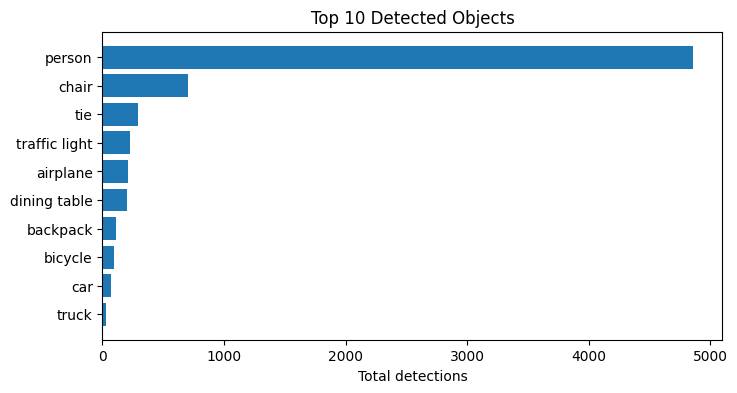

In [34]:
# count total objects
from collections import Counter
all_objs = Counter()
for oc in df["object_counts"]:
    all_objs.update(oc)
top10 = all_objs.most_common(10)
labels, counts = zip(*top10)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.barh(range(len(labels)), counts)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Total detections")
plt.title("Top 10 Detected Objects")
plt.gca().invert_yaxis()
plt.show()


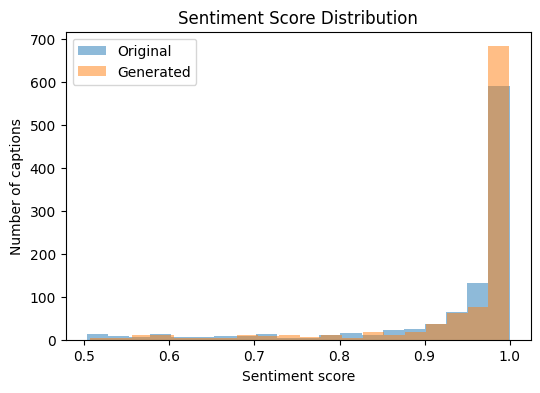

In [35]:
orig_scores = [s["score"] for s in df["orig_sentiment"]]
gen_scores  = [s["score"] for s in df["gen_sentiment"]]

plt.figure(figsize=(6,4))
plt.hist(orig_scores, bins=20, alpha=0.5, label="Original")
plt.hist(gen_scores,  bins=20, alpha=0.5, label="Generated")
plt.xlabel("Sentiment score")
plt.ylabel("Number of captions")
plt.legend()
plt.title("Sentiment Score Distribution")
plt.show()


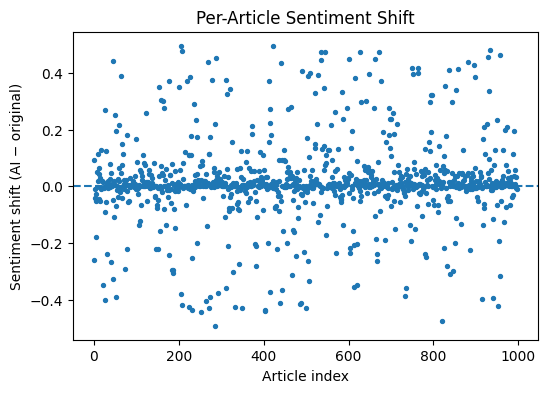

In [36]:
shifts = [g["score"] - o["score"] 
          for o, g in zip(df["orig_sentiment"], df["gen_sentiment"])]

plt.figure(figsize=(6,4))
plt.scatter(range(len(shifts)), shifts, s=8)
plt.axhline(0, linestyle="--")
plt.xlabel("Article index")
plt.ylabel("Sentiment shift (AI − original)")
plt.title("Per-Article Sentiment Shift")
plt.show()


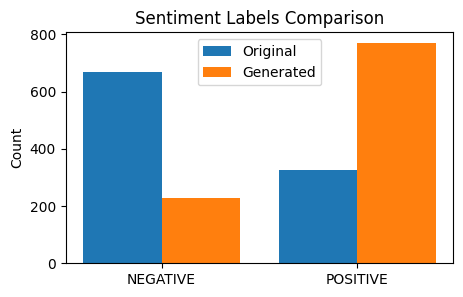

In [38]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def label_counts(col):
    cnt = Counter([s["label"] for s in df[col]])
    return [cnt.get("NEGATIVE", 0), cnt.get("POSITIVE", 0)]

orig_cnt = label_counts("orig_sentiment")
gen_cnt  = label_counts("gen_sentiment")

labels = ["NEGATIVE", "POSITIVE"]
x = np.arange(len(labels))

plt.figure(figsize=(5,3))
plt.bar(x - 0.2, orig_cnt, width=0.4, label="Original")
plt.bar(x + 0.2, gen_cnt,  width=0.4, label="Generated")
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Sentiment Labels Comparison")
plt.legend()
plt.show()


'Top-5 Object Counts per Article'

,person,chair,tie,traffic light,airplane
Art 0,10,0,1,0,0
Art 1,1,0,0,0,0
Art 2,0,0,0,0,0
Art 3,0,0,0,0,0
Art 5,1,0,0,0,0
...,...,...,...,...,...
Art 1042,10,0,0,2,0
Art 1043,2,2,1,0,0
Art 1044,12,0,0,0,0
Art 1045,3,7,0,0,0


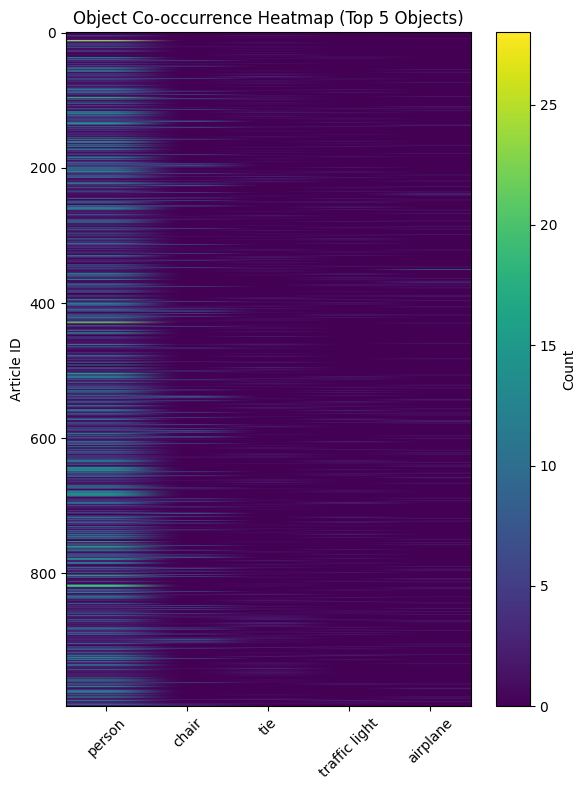

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# Assuming `df` is your existing DataFrame from the records
# 1. Identify top-5 most common objects
all_objs = Counter()
for counts in df['object_counts']:
    all_objs.update(counts)
top5 = [obj for obj, _ in all_objs.most_common(5)]

# 2. Build a DataFrame of counts for these top-5 objects per article
heat_matrix = []
for counts in df['object_counts']:
    heat_matrix.append([counts.get(obj, 0) for obj in top5])

heat_df = pd.DataFrame(
    heat_matrix,
    columns=top5,
    index=[f"Art {i}" for i in df['id']]
)

# Display the DataFrame for inspection
display("Top-5 Object Counts per Article", heat_df)

# 3. Plot heatmap
plt.figure(figsize=(6, 8))
plt.imshow(heat_df.values, aspect='auto')
plt.colorbar(label="Count")
plt.xticks(np.arange(len(top5)), top5, rotation=45)
plt.ylabel("Article ID")
plt.title("Object Co-occurrence Heatmap (Top 5 Objects)")
plt.tight_layout()
plt.show()


In [43]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer("all-MiniLM-L6-v2").to(device)
sims = []
for orig, gen in zip(df.orig_caption, df.gen_caption):
    emb = model.encode([orig, gen], convert_to_tensor=True, device=device)
    sims.append(cosine_similarity(emb[0].cpu().numpy().reshape(1,-1),
                                  emb[1].cpu().numpy().reshape(1,-1))[0][0])
df["caption_similarity"] = sims
df["framing_divergence"] = 1 - df["caption_similarity"]


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


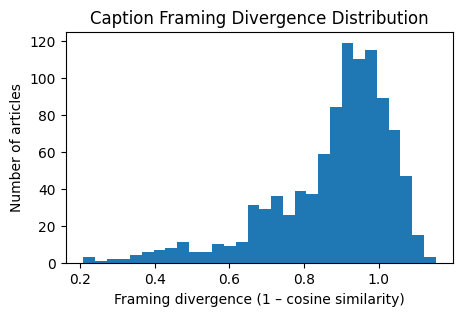

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.hist(df["framing_divergence"], bins=30)
plt.xlabel("Framing divergence (1 – cosine similarity)")
plt.ylabel("Number of articles")
plt.title("Caption Framing Divergence Distribution")
plt.show()


In [58]:
# sort descending by divergence
top_biased = df.sort_values("framing_divergence", ascending=False).head(10)
display(top_biased[["id","title","url","framing_divergence","orig_caption","gen_caption"]])


KeyError: 'framing_divergence'

In [60]:
display(top_biased[["id","title","url","framing_divergence","orig_caption","gen_caption"]])

,id,title,url,framing_divergence,orig_caption,gen_caption
575,602,Hamas armed wing says still committed to truce...,https://www.hindustantimes.com/world-news/hama...,1.151932,Hamas armed wing says still committed to truce...,travel concept with famous landmarks and famou...
553,577,Syria interim president seeks pressure on Isra...,https://www.hindustantimes.com/world-news/syri...,1.144510,Syria interim president seeks pressure on Isra...,"times square, new york, ny"
702,741,US official blames South Korea's watchlist sta...,https://www.hindustantimes.com/world-news/us-n...,1.127326,US official blames South Korea's watchlist sta...,a street scene with a cafe and a bicycle
209,218,N. Korea says US 'Golden Dome' missile shield ...,https://www.hindustantimes.com/world-news/us-n...,1.120264,N. Korea says US 'Golden Dome' missile shield ...,a street scene with a cafe and a bicycle
706,745,MI6 has never had a woman spy chief. That migh...,https://www.hindustantimes.com/world-news/mi6-...,1.118801,"The British foreign intelligence agency, MI6, ...",a large building with many windows on top of it
123,128,Trump likely to confront South Africa's Ramaph...,https://www.hindustantimes.com/world-news/us-n...,1.118071,Trump likely to confront South Africa's Ramaph...,a group of people walking around a city
766,809,US gave Syria list of conditions for partial s...,https://www.hindustantimes.com/world-news/us-n...,1.117020,US gave Syria list of conditions for partial s...,a street scene with a cafe and a bicycle
183,191,'Not fair': How US students reacted to Trump's...,https://www.hindustantimes.com/world-news/us-n...,1.116912,A student speaks about the Trump administratio...,a man wearing a plaid shirt
514,537,Trump's Oval Office thrashing of Zelenskyy sho...,https://www.hindustantimes.com/world-news/us-n...,1.112631,Trump's Oval Office thrashing of Zelenskyy sho...,a street scene with a cafe and a bicycle
757,797,Universities Sprint from ‘We Will Not Cower’ t...,https://www.hindustantimes.com/world-news/univ...,1.109809,Universities Sprint from ‘We Will Not Cower’ t...,a group of people walking around a park


In [61]:
top_biased.to_csv("top_biased_articles.csv", index=False)

In [62]:
actor_prompts = [
  "Israeli soldier", 
  "Palestinian militant", 
  "Palestinian civilian", 
  "Israeli civilian",
  "journalist",
  "refugee"
]
scene_prompts = [
  "destruction", 
  "protest", 
  "military operation", 
  "peaceful gathering", 
  "press conference"
]


In [63]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [64]:
import torch

text_inputs = proc(text=actor_prompts + scene_prompts, 
                   padding=True, return_tensors="pt").to(device)
text_embs   = clip.get_text_features(**text_inputs)  # shape (N_prompts, D)


In [70]:
from collections import Counter
import numpy as np

# Ensure these are in scope from your earlier cell:
# device, clip (CLIPModel), proc (CLIPProcessor), actor_prompts, scene_prompts, text_embs

def classify_image(img: Image.Image) -> dict:
    # 1. Prepare image tensor
    img_input = proc(images=img, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        # 2. Get normalized image embedding
        img_emb = clip.get_image_features(**img_input)
        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
        # 3. Compute similarities
        sims = (img_emb @ text_embs.T).cpu().numpy()[0]

    # 4. Split into actor vs scene
    actor_sims = sims[: len(actor_prompts)]
    scene_sims = sims[len(actor_prompts):]

    # 5. Pick top labels
    actor_idx = int(np.argmax(actor_sims))
    scene_idx = int(np.argmax(scene_sims))

    return {
        "actor":       actor_prompts[actor_idx],
        "actor_score": float(actor_sims[actor_idx]),
        "scene":       scene_prompts[scene_idx],
        "scene_score": float(scene_sims[scene_idx]),
    }

print("✅ classify_image updated to use `proc` and `clip`.")


✅ classify_image updated to use `proc` and `clip`.


In [79]:
records = []
for art in tqdm(articles[:1000], desc="Processing first 1000 articles"):
    imgs = art.get("local_images", [])
    
    if not imgs: continue
    img_path = imgs[0]

    img_path = imgs[0]
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"⚠️ Skipping {img_path}: {e}")
        continue

    # Zero‐shot actor/scene
    ci = classify_image(img)

    orig_caption = art.get("captions", [""])[0]
    try:
        gen_caption = generate_caption(img)
        objs        = detect_objects(img)
        sent_orig   = sentiment_analyzer(orig_caption)[0]
        sent_gen    = sentiment_analyzer(gen_caption)[0]
    except Exception as e:
        print(f"⚠️ Error processing {art['id']} – {e}")
        continue

    records.append({
        **ci,
        "id":             art["id"],
        "title":          art["title"],
        "url":            art.get("url", ""),
        "img_path":       img_path,  
        "orig_caption":   orig_caption,
        "gen_caption":    gen_caption,
        "orig_sentiment": sent_orig,
        "gen_sentiment":  sent_gen,
        "object_counts":  objs
    })

df = pd.DataFrame(records)
display(df)


Processing first 1000 articles:   0%|          | 0/1000 [00:00<?, ?it/s]


0: 384x640 10 persons, 1 tie, 1 laptop, 5.5ms
Speed: 2.7ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 1/1000 [00:00<06:41,  2.49it/s]


0: 384x640 1 person, 2 cars, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 2/1000 [00:00<05:04,  3.28it/s]


0: 384x640 1 bed, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 3/1000 [00:00<05:04,  3.28it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 4/1000 [00:01<04:35,  3.62it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   0%|          | 5/1000 [00:01<04:54,  3.38it/s]


0: 384x640 7 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 6/1000 [00:01<04:41,  3.53it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 7/1000 [00:02<04:55,  3.36it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 8/1000 [00:02<05:12,  3.18it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 9/1000 [00:02<05:23,  3.06it/s]


0: 384x640 1 airplane, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 10/1000 [00:03<04:54,  3.36it/s]


0: 384x640 2 persons, 1 car, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 11/1000 [00:03<05:11,  3.18it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|          | 12/1000 [00:03<05:16,  3.12it/s]


0: 384x640 28 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|▏         | 13/1000 [00:04<05:05,  3.23it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   1%|▏         | 14/1000 [00:04<05:05,  3.22it/s]


0: 384x640 5 persons, 2 cars, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 15/1000 [00:04<04:31,  3.63it/s]


0: 384x640 1 person, 1 umbrella, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 16/1000 [00:04<04:53,  3.35it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 17/1000 [00:05<05:01,  3.26it/s]


0: 384x640 7 persons, 1 truck, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 18/1000 [00:05<05:15,  3.11it/s]


0: 384x640 3 persons, 1 book, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 19/1000 [00:05<05:10,  3.16it/s]


0: 384x640 5 persons, 1 truck, 1 frisbee, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 20/1000 [00:06<05:27,  2.99it/s]


0: 384x640 3 persons, 1 boat, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 21/1000 [00:06<04:50,  3.36it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 22/1000 [00:06<04:39,  3.50it/s]


0: 384x640 13 persons, 2 cell phones, 1 book, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 23/1000 [00:07<04:51,  3.35it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▏         | 24/1000 [00:07<05:00,  3.25it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   2%|▎         | 25/1000 [00:07<06:07,  2.65it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 26/1000 [00:08<05:45,  2.82it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 27/1000 [00:08<05:44,  2.83it/s]


0: 384x640 5 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 28/1000 [00:08<05:22,  3.01it/s]


0: 384x640 6 persons, 1 handbag, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 29/1000 [00:09<05:07,  3.15it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 30/1000 [00:09<05:11,  3.12it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 31/1000 [00:09<05:13,  3.10it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 32/1000 [00:09<04:46,  3.38it/s]


0: 384x640 1 boat, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 33/1000 [00:10<04:21,  3.70it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   3%|▎         | 34/1000 [00:10<04:23,  3.66it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▎         | 35/1000 [00:10<03:57,  4.06it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▎         | 36/1000 [00:11<04:43,  3.40it/s]


0: 384x640 1 traffic light, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▎         | 37/1000 [00:11<04:24,  3.64it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 38/1000 [00:11<04:25,  3.62it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 39/1000 [00:11<04:19,  3.70it/s]


0: 384x640 1 person, 1 tie, 1 sports ball, 1 cup, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 40/1000 [00:12<04:22,  3.66it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 41/1000 [00:12<04:23,  3.64it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 42/1000 [00:12<04:58,  3.21it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 43/1000 [00:13<04:55,  3.24it/s]


0: 384x640 3 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 44/1000 [00:13<06:00,  2.65it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   4%|▍         | 45/1000 [00:13<05:38,  2.82it/s]


0: 384x640 1 person, 1 cup, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 46/1000 [00:14<05:33,  2.86it/s]


0: 384x640 5 persons, 1 tie, 1 cake, 1 chair, 1 dining table, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 47/1000 [00:14<05:46,  2.75it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 48/1000 [00:15<05:42,  2.78it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▍         | 49/1000 [00:15<05:33,  2.85it/s]


0: 384x640 6 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 50/1000 [00:15<05:45,  2.75it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 51/1000 [00:16<05:27,  2.89it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 52/1000 [00:16<05:35,  2.82it/s]


0: 384x640 10 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 53/1000 [00:16<05:35,  2.82it/s]


0: 384x640 5 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   5%|▌         | 54/1000 [00:17<05:21,  2.94it/s]


0: 384x640 14 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 55/1000 [00:17<05:24,  2.91it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 56/1000 [00:17<05:26,  2.89it/s]


0: 384x640 13 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 57/1000 [00:18<05:13,  3.01it/s]


0: 384x640 5 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 58/1000 [00:18<04:51,  3.23it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 59/1000 [00:18<04:42,  3.33it/s]


0: 384x640 1 person, 2 airplanes, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 60/1000 [00:18<04:56,  3.17it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 61/1000 [00:19<04:25,  3.54it/s]


0: 384x640 4 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▌         | 62/1000 [00:19<04:11,  3.73it/s]


0: 384x640 7 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▋         | 63/1000 [00:19<04:41,  3.33it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▋         | 64/1000 [00:20<04:41,  3.33it/s]


0: 384x640 7 persons, 1 surfboard, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   6%|▋         | 65/1000 [00:20<04:48,  3.24it/s]


0: 384x640 2 persons, 3 ties, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 66/1000 [00:20<05:00,  3.11it/s]


0: 384x640 3 persons, 2 ties, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 67/1000 [00:21<04:48,  3.24it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 68/1000 [00:21<04:55,  3.15it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 69/1000 [00:21<04:52,  3.19it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 70/1000 [00:21<04:36,  3.36it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 71/1000 [00:22<04:31,  3.42it/s]


0: 384x640 1 person, 1 tie, 2 wine glasss, 2 cups, 1 cake, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 72/1000 [00:22<05:01,  3.07it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 73/1000 [00:23<05:22,  2.88it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   7%|▋         | 74/1000 [00:23<04:43,  3.27it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 75/1000 [00:23<04:55,  3.13it/s]


0: 384x640 2 persons, 1 umbrella, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 76/1000 [00:23<05:04,  3.04it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 77/1000 [00:24<04:52,  3.15it/s]


0: 384x640 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 78/1000 [00:24<04:49,  3.19it/s]


0: 384x640 9 persons, 1 handbag, 1 kite, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 79/1000 [00:24<04:41,  3.27it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 80/1000 [00:25<04:21,  3.52it/s]


0: 384x640 1 person, 1 tie, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 81/1000 [00:25<04:54,  3.12it/s]


0: 384x640 2 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 82/1000 [00:25<04:58,  3.08it/s]


0: 384x640 3 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 83/1000 [00:26<04:36,  3.32it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 84/1000 [00:26<04:05,  3.73it/s]


0: 384x640 11 persons, 1 handbag, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   8%|▊         | 85/1000 [00:26<04:07,  3.69it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▊         | 86/1000 [00:26<04:03,  3.75it/s]


0: 384x640 5 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▊         | 87/1000 [00:27<05:19,  2.85it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 88/1000 [00:27<05:06,  2.97it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 89/1000 [00:27<04:51,  3.13it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 90/1000 [00:28<04:33,  3.33it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 91/1000 [00:28<04:33,  3.32it/s]


0: 384x640 7 persons, 1 surfboard, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 92/1000 [00:28<04:34,  3.31it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 93/1000 [00:29<04:34,  3.30it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:   9%|▉         | 94/1000 [00:29<04:53,  3.09it/s]


0: 384x640 2 persons, 2 ties, 1 bowl, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 95/1000 [00:29<04:16,  3.53it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 96/1000 [00:29<04:34,  3.29it/s]


0: 384x640 19 persons, 1 umbrella, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 97/1000 [00:30<04:39,  3.23it/s]


0: 384x640 11 persons, 2 ties, 5.1ms
Speed: 2.8ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 98/1000 [00:30<04:38,  3.24it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|▉         | 99/1000 [00:30<04:36,  3.26it/s]


0: 384x640 12 persons, 1 tie, 1 bowl, 1 chair, 2 potted plants, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 100/1000 [00:31<04:30,  3.33it/s]


0: 384x640 1 person, 1 tie, 1 surfboard, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 101/1000 [00:31<04:36,  3.25it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 102/1000 [00:31<04:35,  3.26it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 103/1000 [00:32<04:28,  3.34it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 104/1000 [00:32<04:22,  3.42it/s]


0: 384x640 1 person, 1 tie, 1 surfboard, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  10%|█         | 105/1000 [00:32<04:31,  3.30it/s]


0: 384x640 12 persons, 1 motorcycle, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 106/1000 [00:32<04:25,  3.37it/s]


0: 384x640 1 person, 1 bench, 1 tie, 1 surfboard, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 107/1000 [00:33<04:02,  3.69it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 108/1000 [00:33<04:41,  3.17it/s]


0: 384x640 5 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 109/1000 [00:33<04:37,  3.21it/s]


0: 384x640 4 persons, 1 car, 1 bus, 1 truck, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 110/1000 [00:34<05:18,  2.79it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 111/1000 [00:34<05:17,  2.80it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█         | 112/1000 [00:35<05:15,  2.81it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█▏        | 113/1000 [00:35<05:13,  2.83it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  11%|█▏        | 114/1000 [00:35<04:47,  3.08it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 115/1000 [00:36<04:41,  3.15it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 116/1000 [00:36<04:49,  3.05it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 117/1000 [00:36<04:55,  2.99it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 118/1000 [00:36<04:40,  3.14it/s]


0: 384x640 8 persons, 4 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 119/1000 [00:37<04:48,  3.05it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 120/1000 [00:37<04:29,  3.26it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 121/1000 [00:37<04:22,  3.35it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 122/1000 [00:38<04:17,  3.41it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 123/1000 [00:38<04:45,  3.08it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▏        | 124/1000 [00:38<04:33,  3.21it/s]


0: 384x640 6 persons, 1 tie, 2 bottles, 2 couchs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  12%|█▎        | 125/1000 [00:39<04:36,  3.16it/s]


0: 384x640 3 persons, 1 tie, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 126/1000 [00:39<04:32,  3.20it/s]


0: 384x640 4 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 127/1000 [00:39<04:36,  3.15it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 128/1000 [00:39<03:55,  3.70it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 129/1000 [00:40<03:51,  3.76it/s]


0: 384x640 4 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 130/1000 [00:40<04:00,  3.62it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 131/1000 [00:40<04:07,  3.52it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 132/1000 [00:41<04:11,  3.45it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 133/1000 [00:41<04:14,  3.40it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  13%|█▎        | 134/1000 [00:41<04:05,  3.53it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▎        | 135/1000 [00:41<04:05,  3.53it/s]


0: 384x640 15 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▎        | 136/1000 [00:42<04:23,  3.28it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▎        | 137/1000 [00:42<04:16,  3.37it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 138/1000 [00:42<04:29,  3.19it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 139/1000 [00:43<04:38,  3.09it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 140/1000 [00:43<04:19,  3.31it/s]


0: 384x640 2 persons, 2 ties, 2 chairs, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 141/1000 [00:43<03:56,  3.63it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 142/1000 [00:44<04:03,  3.53it/s]

⚠️ Skipping ../data/images/ht_art148_img1_550x309.jpg: cannot identify image file '../data/images/ht_art148_img1_550x309.jpg'

0: 384x640 3 persons, 2 trucks, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


/mnt/raid1/MSCs/AY2425/skaul/miniconda3/envs/scraper/lib/python3.10/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
Processing first 1000 articles:  14%|█▍        | 144/1000 [00:44<02:47,  5.12it/s]


0: 384x640 7 persons, 1 car, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  14%|█▍        | 145/1000 [00:44<03:14,  4.39it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 146/1000 [00:44<03:31,  4.04it/s]


0: 384x640 5 persons, 3 cars, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 147/1000 [00:45<03:43,  3.81it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 148/1000 [00:45<04:26,  3.19it/s]


0: 384x640 1 person, 4 cars, 1 bus, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▍        | 149/1000 [00:45<04:29,  3.16it/s]


0: 384x640 2 persons, 1 refrigerator, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 150/1000 [00:46<04:48,  2.94it/s]


0: 384x640 2 persons, 1 car, 1 truck, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 151/1000 [00:46<04:33,  3.10it/s]


0: 384x640 3 persons, 1 bus, 1 truck, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 152/1000 [00:46<04:11,  3.37it/s]


0: 384x640 2 persons, 2 cars, 1 traffic light, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 153/1000 [00:47<04:12,  3.35it/s]


0: 384x640 1 person, 1 cat, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  15%|█▌        | 154/1000 [00:47<04:19,  3.26it/s]


0: 384x640 5 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 155/1000 [00:47<04:18,  3.27it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 156/1000 [00:48<04:17,  3.27it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 157/1000 [00:48<04:22,  3.21it/s]


0: 384x640 13 persons, 1 handbag, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 158/1000 [00:48<05:19,  2.64it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 159/1000 [00:49<04:54,  2.86it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 160/1000 [00:49<04:42,  2.98it/s]


0: 384x640 17 persons, 1 truck, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 161/1000 [00:49<04:34,  3.06it/s]


0: 384x640 1 clock, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▌        | 162/1000 [00:50<04:10,  3.34it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▋        | 163/1000 [00:50<03:59,  3.50it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▋        | 164/1000 [00:50<03:56,  3.53it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  16%|█▋        | 165/1000 [00:50<03:55,  3.55it/s]


0: 384x640 2 persons, 1 car, 1 bus, 1 truck, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 166/1000 [00:51<03:42,  3.75it/s]


0: 384x640 2 persons, 1 car, 1 bus, 1 traffic light, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 167/1000 [00:51<03:33,  3.90it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 168/1000 [00:51<03:39,  3.80it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 169/1000 [00:51<04:00,  3.46it/s]


0: 384x640 14 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 170/1000 [00:52<03:57,  3.50it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 171/1000 [00:52<03:49,  3.61it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 172/1000 [00:52<04:31,  3.05it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 173/1000 [00:53<04:18,  3.20it/s]


0: 384x640 8 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  17%|█▋        | 174/1000 [00:53<04:10,  3.30it/s]


0: 384x640 9 persons, 2 backpacks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 175/1000 [00:53<03:52,  3.54it/s]


0: 384x640 10 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 176/1000 [00:54<04:14,  3.23it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 177/1000 [00:54<04:24,  3.11it/s]


0: 384x640 5 persons, 1 laptop, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 178/1000 [00:54<04:25,  3.09it/s]


0: 384x640 1 person, 1 dog, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 179/1000 [00:55<04:14,  3.22it/s]


0: 384x640 1 person, 3 cars, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 180/1000 [00:55<04:06,  3.32it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 181/1000 [00:55<04:18,  3.17it/s]


0: 384x640 9 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 182/1000 [00:56<04:09,  3.28it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 183/1000 [00:56<04:07,  3.30it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 184/1000 [00:56<04:19,  3.14it/s]


0: 384x640 1 person, 1 umbrella, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  18%|█▊        | 185/1000 [00:56<03:58,  3.41it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▊        | 186/1000 [00:57<03:49,  3.55it/s]


0: 384x640 12 persons, 1 backpack, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▊        | 187/1000 [00:57<03:48,  3.56it/s]


0: 384x640 7 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 188/1000 [00:57<04:05,  3.30it/s]


0: 384x640 2 persons, 1 handbag, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 189/1000 [00:58<03:59,  3.38it/s]


0: 384x640 11 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 190/1000 [00:58<04:06,  3.29it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 191/1000 [00:58<03:54,  3.46it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 192/1000 [00:59<04:14,  3.18it/s]


0: 384x640 3 persons, 1 tie, 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 193/1000 [00:59<04:10,  3.22it/s]


0: 384x640 5 persons, 1 boat, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  19%|█▉        | 194/1000 [00:59<04:31,  2.97it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 195/1000 [00:59<04:17,  3.13it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 196/1000 [01:00<04:12,  3.18it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 197/1000 [01:00<04:03,  3.30it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 2.8ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 198/1000 [01:00<04:04,  3.28it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|█▉        | 199/1000 [01:01<04:03,  3.28it/s]


0: 384x640 6 persons, 1 truck, 1 backpack, 1 handbag, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 200/1000 [01:01<03:58,  3.36it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 201/1000 [01:01<03:59,  3.33it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 202/1000 [01:02<03:49,  3.48it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 203/1000 [01:02<03:47,  3.51it/s]


0: 384x640 4 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 204/1000 [01:02<03:51,  3.44it/s]


0: 384x640 12 persons, 2 cups, 1 laptop, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  20%|██        | 205/1000 [01:03<04:17,  3.09it/s]


0: 384x640 3 persons, 1 chair, 1 potted plant, 1 dining table, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 206/1000 [01:03<04:06,  3.22it/s]


0: 384x640 16 persons, 1 tie, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 207/1000 [01:03<04:21,  3.03it/s]


0: 384x640 11 persons, 1 truck, 1 traffic light, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 208/1000 [01:04<04:26,  2.97it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 209/1000 [01:04<04:07,  3.20it/s]


0: 384x640 2 persons, 1 tie, 1 surfboard, 1 chair, 1 couch, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 210/1000 [01:04<03:48,  3.46it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 211/1000 [01:04<03:51,  3.40it/s]


0: 384x640 6 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██        | 212/1000 [01:05<03:59,  3.29it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██▏       | 213/1000 [01:05<04:10,  3.14it/s]


0: 384x640 11 persons, 2 cars, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  21%|██▏       | 214/1000 [01:05<03:38,  3.60it/s]


0: 384x640 8 persons, 4 ties, 2 chairs, 1 tv, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 215/1000 [01:06<04:01,  3.25it/s]


0: 384x640 4 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 216/1000 [01:06<03:37,  3.60it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 217/1000 [01:06<03:32,  3.68it/s]


0: 384x640 1 person, 2 ties, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 218/1000 [01:06<03:50,  3.39it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 219/1000 [01:07<03:30,  3.71it/s]


0: 384x640 1 person, 2 ties, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 220/1000 [01:07<03:32,  3.67it/s]


0: 384x640 4 persons, 1 bottle, 2 chairs, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 221/1000 [01:07<03:38,  3.56it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 222/1000 [01:08<03:54,  3.32it/s]


0: 384x640 2 persons, 3 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 223/1000 [01:08<03:37,  3.57it/s]


0: 384x640 11 persons, 3 cars, 1 elephant, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▏       | 224/1000 [01:08<03:15,  3.97it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  22%|██▎       | 225/1000 [01:08<03:27,  3.74it/s]


0: 384x640 17 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 226/1000 [01:09<03:40,  3.51it/s]


0: 384x640 2 persons, 1 bench, 2 backpacks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 227/1000 [01:09<03:39,  3.52it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 228/1000 [01:09<03:43,  3.45it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 229/1000 [01:09<03:46,  3.40it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 230/1000 [01:10<03:58,  3.23it/s]


0: 384x640 4 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 231/1000 [01:10<04:17,  2.98it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 232/1000 [01:10<03:58,  3.22it/s]


0: 384x640 1 person, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 233/1000 [01:11<03:39,  3.49it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  23%|██▎       | 234/1000 [01:11<03:43,  3.43it/s]


0: 384x640 3 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▎       | 235/1000 [01:11<03:56,  3.23it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▎       | 236/1000 [01:12<03:59,  3.19it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▎       | 237/1000 [01:12<03:46,  3.37it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 238/1000 [01:12<03:58,  3.20it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 239/1000 [01:13<04:03,  3.13it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 240/1000 [01:13<04:09,  3.05it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 241/1000 [01:13<04:13,  2.99it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 242/1000 [01:14<04:16,  2.95it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 243/1000 [01:14<04:18,  2.93it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 244/1000 [01:14<04:15,  2.96it/s]


0: 384x640 1 car, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  24%|██▍       | 245/1000 [01:15<04:12,  2.99it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 246/1000 [01:15<04:15,  2.95it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 247/1000 [01:15<04:07,  3.04it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 248/1000 [01:16<03:50,  3.27it/s]


0: 384x640 1 cake, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▍       | 249/1000 [01:16<03:24,  3.68it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 250/1000 [01:16<03:47,  3.30it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 251/1000 [01:16<03:47,  3.30it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 252/1000 [01:17<03:36,  3.46it/s]


0: 384x640 2 persons, 2 ties, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 253/1000 [01:17<03:38,  3.41it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  25%|██▌       | 254/1000 [01:17<03:29,  3.56it/s]


0: 384x640 4 persons, 2 cars, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 255/1000 [01:18<03:29,  3.56it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 256/1000 [01:18<03:23,  3.66it/s]


0: 384x640 1 train, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 257/1000 [01:18<03:08,  3.94it/s]


0: 384x640 11 persons, 2 chairs, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 258/1000 [01:18<03:14,  3.82it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 259/1000 [01:19<03:23,  3.65it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 260/1000 [01:19<03:18,  3.72it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 261/1000 [01:19<03:15,  3.78it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▌       | 262/1000 [01:19<03:18,  3.72it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▋       | 263/1000 [01:20<03:20,  3.67it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▋       | 264/1000 [01:20<03:16,  3.74it/s]


0: 384x640 1 person, 2 airplanes, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  26%|██▋       | 265/1000 [01:20<03:33,  3.44it/s]


0: 384x640 3 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 266/1000 [01:21<03:40,  3.32it/s]


0: 384x640 1 person, 1 tie, 1 clock, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 267/1000 [01:21<03:40,  3.32it/s]


0: 384x640 3 persons, 1 car, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 268/1000 [01:21<04:32,  2.69it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 269/1000 [01:22<04:42,  2.59it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 270/1000 [01:22<04:33,  2.67it/s]


0: 384x640 4 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 271/1000 [01:22<04:18,  2.82it/s]


0: 384x640 9 persons, 1 frisbee, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 272/1000 [01:23<03:41,  3.28it/s]


0: 384x640 2 persons, 2 ties, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 273/1000 [01:23<04:22,  2.77it/s]


0: 384x640 2 persons, 1 tie, 1 chair, 1 couch, 1 laptop, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  27%|██▋       | 274/1000 [01:23<04:04,  2.97it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 275/1000 [01:24<04:02,  2.99it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 276/1000 [01:24<03:59,  3.02it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 277/1000 [01:24<03:38,  3.31it/s]


0: 384x640 3 persons, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 278/1000 [01:25<03:32,  3.39it/s]


0: 384x640 5 persons, 1 car, 2 umbrellas, 2 chairs, 1 vase, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 279/1000 [01:25<03:09,  3.80it/s]


0: 384x640 15 persons, 1 car, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 280/1000 [01:25<03:12,  3.74it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 281/1000 [01:25<03:29,  3.43it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 282/1000 [01:26<03:20,  3.58it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 283/1000 [01:26<03:25,  3.48it/s]


0: 384x640 8 persons, 2 cell phones, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 284/1000 [01:26<03:24,  3.51it/s]


0: 384x640 1 umbrella, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  28%|██▊       | 285/1000 [01:26<03:07,  3.81it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▊       | 286/1000 [01:27<03:46,  3.15it/s]


0: 384x640 7 persons, 1 car, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▊       | 287/1000 [01:27<03:38,  3.27it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 288/1000 [01:28<03:46,  3.14it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 289/1000 [01:28<03:52,  3.06it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 290/1000 [01:28<03:51,  3.06it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 291/1000 [01:28<03:36,  3.27it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 292/1000 [01:29<03:35,  3.28it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 293/1000 [01:29<03:44,  3.14it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  29%|██▉       | 294/1000 [01:29<03:38,  3.24it/s]


0: 384x640 2 persons, 2 ties, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 295/1000 [01:30<03:20,  3.52it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 296/1000 [01:30<03:53,  3.02it/s]


0: 384x640 1 person, 4.6ms
Speed: 2.5ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 297/1000 [01:31<04:17,  2.73it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 298/1000 [01:31<04:23,  2.66it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|██▉       | 299/1000 [01:31<04:03,  2.88it/s]


0: 384x640 1 person, 1 tie, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 300/1000 [01:31<03:43,  3.13it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 301/1000 [01:32<03:49,  3.04it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 302/1000 [01:32<03:34,  3.26it/s]


0: 384x640 1 train, 2 trucks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 303/1000 [01:32<03:32,  3.27it/s]


0: 384x640 2 persons, 1 tie, 1 chair, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 304/1000 [01:33<03:31,  3.29it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  30%|███       | 305/1000 [01:33<03:40,  3.15it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 306/1000 [01:33<03:16,  3.53it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 307/1000 [01:33<03:10,  3.64it/s]


0: 384x640 1 person, 1 tie, 1 clock, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 308/1000 [01:34<03:25,  3.37it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 309/1000 [01:34<03:15,  3.53it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 310/1000 [01:34<03:38,  3.16it/s]


0: 384x640 5 persons, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 311/1000 [01:35<03:49,  3.00it/s]


0: 384x640 3 persons, 1 cell phone, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███       | 312/1000 [01:35<03:37,  3.16it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███▏      | 313/1000 [01:35<03:19,  3.44it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  31%|███▏      | 314/1000 [01:36<03:12,  3.57it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 315/1000 [01:36<03:10,  3.59it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 316/1000 [01:36<03:15,  3.50it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 317/1000 [01:36<03:18,  3.44it/s]


0: 384x640 2 persons, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 318/1000 [01:37<03:20,  3.40it/s]


0: 384x640 3 persons, 1 car, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 319/1000 [01:37<03:21,  3.38it/s]


0: 384x640 5 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 320/1000 [01:37<03:17,  3.44it/s]


0: 384x640 1 person, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 321/1000 [01:38<03:06,  3.65it/s]


0: 384x640 1 person, 1 motorcycle, 1 bird, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 322/1000 [01:38<03:58,  2.85it/s]


0: 384x640 5 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 323/1000 [01:38<03:57,  2.86it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▏      | 324/1000 [01:39<03:56,  2.86it/s]


0: 384x640 1 person, 1 tie, 1 chair, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  32%|███▎      | 325/1000 [01:39<03:55,  2.87it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 326/1000 [01:39<03:35,  3.12it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 327/1000 [01:40<03:22,  3.32it/s]


0: 384x640 1 book, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 328/1000 [01:40<02:54,  3.86it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 329/1000 [01:40<03:02,  3.68it/s]


0: 384x640 1 boat, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 330/1000 [01:40<02:46,  4.03it/s]


0: 384x640 1 person, 1 motorcycle, 1 bird, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 331/1000 [01:41<03:10,  3.52it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 332/1000 [01:41<03:03,  3.64it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 333/1000 [01:41<03:03,  3.63it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  33%|███▎      | 334/1000 [01:42<03:45,  2.95it/s]


0: 384x640 3 persons, 2 ties, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▎      | 335/1000 [01:42<03:28,  3.19it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▎      | 336/1000 [01:42<03:15,  3.39it/s]


0: 384x640 1 laptop, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▎      | 337/1000 [01:42<03:12,  3.45it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 338/1000 [01:43<02:50,  3.87it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 339/1000 [01:43<02:59,  3.68it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 340/1000 [01:43<03:18,  3.32it/s]


0: 384x640 4 persons, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 341/1000 [01:44<03:13,  3.40it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 342/1000 [01:44<03:24,  3.22it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 343/1000 [01:44<03:31,  3.10it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 344/1000 [01:45<03:40,  2.97it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  34%|███▍      | 345/1000 [01:45<03:19,  3.28it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 346/1000 [01:45<03:13,  3.38it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 347/1000 [01:46<03:32,  3.07it/s]


0: 384x640 10 persons, 2 traffic lights, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 348/1000 [01:46<03:17,  3.30it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▍      | 349/1000 [01:46<03:26,  3.16it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 350/1000 [01:47<03:22,  3.21it/s]


0: 384x640 2 persons, 2 ties, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 351/1000 [01:47<03:56,  2.74it/s]


0: 384x640 11 persons, 2 backpacks, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 352/1000 [01:47<04:02,  2.68it/s]


0: 384x640 11 airplanes, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 353/1000 [01:48<03:47,  2.84it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  35%|███▌      | 354/1000 [01:48<03:41,  2.91it/s]


0: 384x640 2 persons, 2 ties, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 355/1000 [01:48<03:33,  3.02it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 356/1000 [01:49<03:22,  3.17it/s]


0: 384x640 1 cake, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 357/1000 [01:49<03:28,  3.08it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 358/1000 [01:49<03:19,  3.22it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 359/1000 [01:49<03:08,  3.40it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 360/1000 [01:50<03:00,  3.54it/s]


0: 384x640 2 persons, 1 tie, 2 surfboards, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 361/1000 [01:50<03:12,  3.31it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▌      | 362/1000 [01:50<03:08,  3.39it/s]


0: 384x640 4 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▋      | 363/1000 [01:51<02:42,  3.92it/s]


0: 384x640 6 persons, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▋      | 364/1000 [01:51<02:46,  3.83it/s]


0: 384x640 1 person, 3 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  36%|███▋      | 365/1000 [01:51<02:49,  3.76it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 366/1000 [01:51<03:04,  3.43it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 367/1000 [01:52<03:01,  3.49it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 368/1000 [01:52<02:54,  3.62it/s]


0: 384x640 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 369/1000 [01:52<02:41,  3.91it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 370/1000 [01:53<02:58,  3.53it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 371/1000 [01:53<03:10,  3.31it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 372/1000 [01:53<03:17,  3.17it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 373/1000 [01:54<03:23,  3.07it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  37%|███▋      | 374/1000 [01:54<03:14,  3.22it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 375/1000 [01:54<03:03,  3.41it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 376/1000 [01:54<03:12,  3.24it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 377/1000 [01:55<03:02,  3.41it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 378/1000 [01:55<03:03,  3.39it/s]


0: 384x640 7 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 379/1000 [01:55<02:55,  3.54it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 380/1000 [01:56<03:07,  3.31it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 381/1000 [01:56<03:06,  3.32it/s]


0: 384x640 1 person, 1 couch, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 382/1000 [01:56<03:06,  3.32it/s]


0: 384x640 3 persons, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 383/1000 [01:56<03:01,  3.40it/s]


0: 384x640 6 persons, 1 car, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 384/1000 [01:57<02:58,  3.45it/s]


0: 384x640 1 person, 1 traffic light, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  38%|███▊      | 385/1000 [01:57<02:47,  3.68it/s]


0: 384x640 14 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▊      | 386/1000 [01:57<02:47,  3.66it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▊      | 387/1000 [01:58<02:56,  3.47it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 388/1000 [01:58<03:03,  3.34it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 389/1000 [01:58<03:07,  3.26it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 390/1000 [01:59<03:05,  3.29it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 391/1000 [01:59<03:23,  2.99it/s]


0: 384x640 10 persons, 2 traffic lights, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 392/1000 [01:59<03:09,  3.20it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 393/1000 [02:00<03:15,  3.10it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  39%|███▉      | 394/1000 [02:00<03:24,  2.97it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 395/1000 [02:00<03:21,  3.00it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 396/1000 [02:00<03:07,  3.22it/s]


0: 384x640 10 persons, 2 traffic lights, 5.3ms
Speed: 2.8ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 397/1000 [02:01<02:57,  3.40it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 398/1000 [02:01<02:55,  3.44it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|███▉      | 399/1000 [02:01<03:05,  3.24it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 400/1000 [02:02<03:04,  3.26it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 401/1000 [02:02<03:11,  3.12it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 402/1000 [02:02<02:59,  3.33it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 403/1000 [02:03<02:55,  3.41it/s]


0: 384x640 10 persons, 2 traffic lights, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 404/1000 [02:03<02:47,  3.56it/s]


0: 384x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  40%|████      | 405/1000 [02:03<02:34,  3.86it/s]


0: 384x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 406/1000 [02:03<02:24,  4.10it/s]


0: 384x640 3 persons, 2 ties, 1 chair, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 407/1000 [02:04<02:47,  3.54it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 408/1000 [02:04<02:58,  3.31it/s]


0: 384x640 4 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 409/1000 [02:04<03:03,  3.23it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 410/1000 [02:05<03:01,  3.25it/s]


0: 384x640 5 persons, 2 ties, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 411/1000 [02:05<03:04,  3.20it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████      | 412/1000 [02:05<02:57,  3.31it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████▏     | 413/1000 [02:05<02:57,  3.31it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  41%|████▏     | 414/1000 [02:06<02:52,  3.39it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 415/1000 [02:06<02:53,  3.38it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 416/1000 [02:06<03:14,  3.00it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 417/1000 [02:07<03:16,  2.96it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 418/1000 [02:07<03:09,  3.06it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 419/1000 [02:07<02:57,  3.27it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 420/1000 [02:08<03:04,  3.15it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 421/1000 [02:08<02:52,  3.35it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 422/1000 [02:08<02:52,  3.34it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 423/1000 [02:09<02:49,  3.41it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▏     | 424/1000 [02:09<02:42,  3.54it/s]


0: 384x640 2 persons, 1 tie, 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  42%|████▎     | 425/1000 [02:09<03:25,  2.79it/s]


0: 384x640 12 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 426/1000 [02:10<03:15,  2.93it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 427/1000 [02:10<03:18,  2.89it/s]


0: 384x640 4 persons, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 428/1000 [02:10<02:50,  3.36it/s]


0: 384x640 1 person, 1 wine glass, 1 chair, 1 dining table, 1 tv, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 429/1000 [02:10<02:34,  3.68it/s]


0: 384x640 19 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 430/1000 [02:11<02:36,  3.64it/s]


0: 384x640 24 persons, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 431/1000 [02:11<02:36,  3.64it/s]


0: 384x640 1 person, 2 airplanes, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 432/1000 [02:11<02:50,  3.32it/s]


0: 384x640 8 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 433/1000 [02:12<02:54,  3.26it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  43%|████▎     | 434/1000 [02:12<03:07,  3.02it/s]


0: 384x640 1 person, 1 tie, 1 cup, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▎     | 435/1000 [02:12<03:08,  3.00it/s]


0: 384x640 13 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▎     | 436/1000 [02:13<03:01,  3.11it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▎     | 437/1000 [02:13<02:59,  3.13it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 438/1000 [02:13<02:57,  3.16it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 439/1000 [02:14<03:01,  3.10it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 440/1000 [02:14<03:03,  3.05it/s]


0: 384x640 1 bus, 1 train, 2 trucks, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 441/1000 [02:14<02:51,  3.25it/s]


0: 384x640 7 persons, 1 elephant, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 442/1000 [02:15<02:49,  3.30it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 443/1000 [02:15<02:46,  3.34it/s]


0: 384x640 2 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 444/1000 [02:15<03:00,  3.08it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  44%|████▍     | 445/1000 [02:16<03:06,  2.98it/s]


0: 384x640 13 persons, 3 handbags, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 446/1000 [02:16<03:16,  2.82it/s]


0: 384x640 4 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 447/1000 [02:16<03:08,  2.93it/s]


0: 384x640 14 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 448/1000 [02:17<03:24,  2.70it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▍     | 449/1000 [02:17<03:18,  2.77it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 450/1000 [02:17<03:14,  2.83it/s]


0: 384x640 1 cake, 1 clock, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 451/1000 [02:18<02:47,  3.28it/s]


0: 384x640 4 persons, 3 ties, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 452/1000 [02:18<02:56,  3.11it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 453/1000 [02:18<02:45,  3.31it/s]


0: 384x640 8 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  45%|████▌     | 454/1000 [02:18<02:26,  3.74it/s]


0: 384x640 2 persons, 1 frisbee, 1 laptop, 1 clock, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 455/1000 [02:19<02:31,  3.59it/s]


0: 384x640 1 person, 1 suitcase, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 456/1000 [02:19<02:35,  3.50it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 457/1000 [02:20<03:15,  2.77it/s]


0: 384x640 1 person, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 458/1000 [02:20<03:20,  2.70it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 459/1000 [02:20<03:28,  2.60it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 460/1000 [02:21<02:59,  3.01it/s]


0: 384x640 1 person, 1 potted plant, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 461/1000 [02:21<02:35,  3.46it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▌     | 462/1000 [02:21<02:44,  3.26it/s]


0: 384x640 5 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▋     | 463/1000 [02:21<02:44,  3.26it/s]


0: 384x640 15 persons, 2 ties, 1 chair, 1 laptop, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▋     | 464/1000 [02:22<02:48,  3.18it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  46%|████▋     | 465/1000 [02:22<03:23,  2.62it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 466/1000 [02:22<02:52,  3.10it/s]


0: 384x640 10 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 467/1000 [02:23<02:48,  3.16it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 468/1000 [02:23<03:07,  2.83it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 469/1000 [02:23<02:59,  2.96it/s]


0: 384x640 1 person, 1 tie, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 470/1000 [02:24<03:08,  2.82it/s]


0: 384x640 1 person, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 471/1000 [02:24<02:48,  3.15it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 472/1000 [02:24<02:45,  3.19it/s]


0: 384x640 1 clock, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 473/1000 [02:25<02:39,  3.31it/s]


0: 384x640 1 person, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  47%|████▋     | 474/1000 [02:25<02:27,  3.56it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 475/1000 [02:25<02:37,  3.33it/s]


0: 384x640 6 persons, 1 suitcase, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 476/1000 [02:26<02:41,  3.24it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 477/1000 [02:26<02:47,  3.12it/s]


0: 384x640 2 persons, 1 bed, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 478/1000 [02:26<02:33,  3.40it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 479/1000 [02:27<03:11,  2.72it/s]


0: 384x640 12 persons, 2 backpacks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 480/1000 [02:27<03:29,  2.48it/s]


0: 384x640 9 persons, 3 ties, 1 dining table, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 481/1000 [02:27<03:10,  2.73it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 482/1000 [02:28<03:17,  2.62it/s]


0: 384x640 3 persons, 2 trucks, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 483/1000 [02:28<02:50,  3.04it/s]


0: 384x640 2 persons, 1 train, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 484/1000 [02:28<02:45,  3.11it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  48%|████▊     | 485/1000 [02:29<02:49,  3.04it/s]


0: 384x640 6 persons, 1 car, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▊     | 486/1000 [02:29<02:55,  2.94it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▊     | 487/1000 [02:30<03:17,  2.60it/s]


0: 384x640 1 person, 1 bus, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 488/1000 [02:30<03:00,  2.84it/s]


0: 384x640 2 persons, 2 chairs, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 489/1000 [02:30<02:41,  3.16it/s]


0: 384x640 14 persons, 3 ties, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 490/1000 [02:30<02:42,  3.13it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 491/1000 [02:31<02:21,  3.60it/s]


0: 384x640 (no detections), 5.4ms
Speed: 2.8ms preprocess, 5.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 492/1000 [02:31<02:07,  3.99it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 493/1000 [02:31<02:23,  3.53it/s]


0: 384x640 16 persons, 5 backpacks, 5 suitcases, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  49%|████▉     | 494/1000 [02:31<02:25,  3.48it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 495/1000 [02:32<02:26,  3.46it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 496/1000 [02:32<03:07,  2.69it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 497/1000 [02:33<02:58,  2.83it/s]


0: 384x640 8 persons, 4 ties, 2 surfboards, 1 cup, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 498/1000 [02:33<02:48,  2.98it/s]


0: 384x640 7 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|████▉     | 499/1000 [02:33<02:48,  2.97it/s]


0: 384x640 3 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 500/1000 [02:34<02:34,  3.24it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 501/1000 [02:34<02:50,  2.92it/s]


0: 384x640 2 persons, 1 tie, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 502/1000 [02:34<02:51,  2.90it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 503/1000 [02:35<02:45,  3.01it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 504/1000 [02:35<02:49,  2.93it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  50%|█████     | 505/1000 [02:35<02:39,  3.10it/s]


0: 384x640 15 persons, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 506/1000 [02:35<02:25,  3.39it/s]


0: 384x640 15 persons, 1 car, 1 handbag, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 507/1000 [02:36<02:30,  3.28it/s]


0: 384x640 8 persons, 2 cell phones, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 508/1000 [02:36<02:33,  3.21it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 509/1000 [02:36<02:38,  3.09it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 510/1000 [02:37<02:31,  3.23it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 511/1000 [02:37<02:23,  3.40it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████     | 512/1000 [02:37<02:22,  3.42it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████▏    | 513/1000 [02:38<02:19,  3.50it/s]


0: 384x640 2 persons, 2 ties, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  51%|█████▏    | 514/1000 [02:38<02:31,  3.21it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 515/1000 [02:38<02:22,  3.40it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 516/1000 [02:38<02:23,  3.37it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 517/1000 [02:39<02:03,  3.91it/s]


0: 384x640 5 persons, 1 car, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 518/1000 [02:39<02:12,  3.63it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 519/1000 [02:39<02:09,  3.71it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 520/1000 [02:39<02:10,  3.68it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 521/1000 [02:40<02:37,  3.04it/s]


0: 384x640 2 persons, 2 umbrellas, 3 ties, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 522/1000 [02:40<02:36,  3.05it/s]


0: 384x640 3 persons, 3 cars, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 523/1000 [02:40<02:19,  3.42it/s]


0: 384x640 1 person, 2 airplanes, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▏    | 524/1000 [02:41<02:26,  3.24it/s]


0: 384x640 8 persons, 1 skateboard, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  52%|█████▎    | 525/1000 [02:41<02:08,  3.69it/s]


0: 384x640 4 persons, 1 tie, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 526/1000 [02:41<02:23,  3.31it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 527/1000 [02:42<02:15,  3.48it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 528/1000 [02:42<02:23,  3.28it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 529/1000 [02:42<02:19,  3.38it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 530/1000 [02:43<02:52,  2.72it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 531/1000 [02:43<02:43,  2.87it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 532/1000 [02:43<02:29,  3.13it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 533/1000 [02:44<02:23,  3.25it/s]


0: 384x640 1 person, 3 trucks, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  53%|█████▎    | 534/1000 [02:44<02:28,  3.14it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▎    | 535/1000 [02:44<02:18,  3.35it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▎    | 536/1000 [02:44<02:03,  3.75it/s]


0: 384x640 9 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▎    | 537/1000 [02:45<02:00,  3.84it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 538/1000 [02:45<01:54,  4.03it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 539/1000 [02:45<01:56,  3.94it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 540/1000 [02:45<02:03,  3.71it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 541/1000 [02:46<02:08,  3.56it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 542/1000 [02:46<02:11,  3.48it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 543/1000 [02:46<02:10,  3.49it/s]


0: 384x640 3 persons, 1 tie, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  54%|█████▍    | 544/1000 [02:47<02:18,  3.30it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 545/1000 [02:47<02:25,  3.13it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 546/1000 [02:47<02:29,  3.04it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 547/1000 [02:48<02:25,  3.11it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 548/1000 [02:48<02:16,  3.31it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▍    | 549/1000 [02:48<02:26,  3.08it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 550/1000 [02:49<02:16,  3.29it/s]


0: 384x640 1 person, 1 tie, 3 books, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 551/1000 [02:49<02:23,  3.13it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 552/1000 [02:49<02:46,  2.69it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 553/1000 [02:50<03:02,  2.45it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  55%|█████▌    | 554/1000 [02:50<02:44,  2.70it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 555/1000 [02:50<02:29,  2.98it/s]


0: 384x640 1 person, 1 truck, 1 boat, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 556/1000 [02:51<02:27,  3.00it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 557/1000 [02:51<02:27,  3.01it/s]


0: 384x640 1 person, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 558/1000 [02:51<02:26,  3.02it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 559/1000 [02:52<02:28,  2.97it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 560/1000 [02:52<02:21,  3.12it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 561/1000 [02:52<02:12,  3.31it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▌    | 562/1000 [02:53<02:06,  3.47it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▋    | 563/1000 [02:53<02:04,  3.50it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▋    | 564/1000 [02:53<02:07,  3.43it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  56%|█████▋    | 565/1000 [02:54<02:14,  3.23it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 566/1000 [02:54<02:07,  3.41it/s]


0: 384x640 8 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 567/1000 [02:54<02:17,  3.15it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 568/1000 [02:55<02:21,  3.06it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 569/1000 [02:55<02:12,  3.26it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 570/1000 [02:55<02:14,  3.20it/s]

⚠️ Skipping ../data/images/ht_art595_img1_550x309.jpg: cannot identify image file '../data/images/ht_art595_img1_550x309.jpg'

0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 572/1000 [02:55<01:42,  4.18it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 573/1000 [02:56<01:48,  3.92it/s]


0: 384x640 4 persons, 1 umbrella, 1 handbag, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▋    | 574/1000 [02:56<01:54,  3.73it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  57%|█████▊    | 575/1000 [02:56<01:52,  3.76it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 576/1000 [02:57<01:51,  3.80it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 577/1000 [02:57<02:01,  3.47it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 578/1000 [02:57<02:09,  3.27it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 579/1000 [02:58<02:14,  3.14it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 580/1000 [02:58<02:06,  3.33it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 581/1000 [02:58<02:11,  3.18it/s]


0: 384x640 9 persons, 1 handbag, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 582/1000 [02:58<02:07,  3.28it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 583/1000 [02:59<02:06,  3.29it/s]


0: 384x640 3 persons, 1 dog, 1 tie, 1 chair, 1 laptop, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 584/1000 [02:59<02:09,  3.22it/s]


0: 384x640 2 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  58%|█████▊    | 585/1000 [02:59<02:08,  3.24it/s]


0: 384x640 1 person, 2 ties, 2 dining tables, 1 book, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▊    | 586/1000 [03:00<02:10,  3.18it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▊    | 587/1000 [03:00<02:15,  3.04it/s]


0: 384x640 10 persons, 3 cars, 1 truck, 1 boat, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 588/1000 [03:00<02:17,  2.99it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 589/1000 [03:01<02:14,  3.06it/s]


0: 384x640 2 persons, 2 skateboards, 5.2ms
Speed: 2.8ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 590/1000 [03:01<02:00,  3.41it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 591/1000 [03:01<01:59,  3.42it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 592/1000 [03:02<02:01,  3.35it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 593/1000 [03:02<02:02,  3.32it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  59%|█████▉    | 594/1000 [03:02<01:51,  3.64it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 595/1000 [03:02<01:55,  3.51it/s]


0: 384x640 10 persons, 3 cars, 1 umbrella, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 596/1000 [03:03<01:43,  3.89it/s]


0: 384x640 11 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 597/1000 [03:03<01:52,  3.58it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 598/1000 [03:03<02:10,  3.08it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|█████▉    | 599/1000 [03:04<02:05,  3.20it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 600/1000 [03:04<02:09,  3.08it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 601/1000 [03:04<02:07,  3.13it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 602/1000 [03:05<02:05,  3.16it/s]


0: 384x640 14 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 603/1000 [03:05<01:50,  3.60it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 604/1000 [03:05<01:59,  3.33it/s]


0: 384x640 1 person, 3 suitcases, 1 chair, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  60%|██████    | 605/1000 [03:06<02:08,  3.08it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 606/1000 [03:06<01:54,  3.43it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 607/1000 [03:06<01:45,  3.73it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 608/1000 [03:06<01:44,  3.77it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 609/1000 [03:06<01:43,  3.79it/s]


0: 384x640 4 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 610/1000 [03:07<01:39,  3.91it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 611/1000 [03:07<01:45,  3.68it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████    | 612/1000 [03:07<01:46,  3.63it/s]


0: 384x640 6 persons, 1 boat, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████▏   | 613/1000 [03:08<01:47,  3.60it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  61%|██████▏   | 614/1000 [03:08<01:56,  3.32it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 615/1000 [03:08<02:01,  3.16it/s]


0: 384x640 14 persons, 1 car, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 616/1000 [03:09<02:00,  3.19it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 617/1000 [03:09<02:07,  3.00it/s]


0: 384x640 3 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 618/1000 [03:09<02:09,  2.94it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 619/1000 [03:10<02:00,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 620/1000 [03:10<01:53,  3.35it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 621/1000 [03:10<01:59,  3.17it/s]


0: 384x640 5 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 622/1000 [03:11<01:55,  3.27it/s]


0: 384x640 6 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 623/1000 [03:11<02:00,  3.12it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▏   | 624/1000 [03:11<01:56,  3.23it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  62%|██████▎   | 625/1000 [03:11<02:01,  3.09it/s]


0: 384x640 8 persons, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 626/1000 [03:12<02:04,  3.00it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 627/1000 [03:12<02:06,  2.94it/s]


0: 384x640 2 persons, 3 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 628/1000 [03:12<02:00,  3.09it/s]


0: 384x640 5 persons, 1 teddy bear, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 629/1000 [03:13<01:55,  3.21it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 630/1000 [03:13<01:59,  3.09it/s]


0: 384x640 8 persons, 1 tie, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 631/1000 [03:13<01:55,  3.19it/s]


0: 384x640 3 persons, 1 dog, 1 tie, 1 chair, 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 632/1000 [03:14<01:57,  3.14it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 633/1000 [03:14<01:54,  3.22it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  63%|██████▎   | 634/1000 [03:14<01:52,  3.25it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▎   | 635/1000 [03:15<01:49,  3.34it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▎   | 636/1000 [03:15<01:44,  3.49it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▎   | 637/1000 [03:15<01:43,  3.52it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 638/1000 [03:15<01:40,  3.61it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 639/1000 [03:16<01:47,  3.35it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 640/1000 [03:16<01:43,  3.49it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 641/1000 [03:16<01:49,  3.27it/s]


0: 384x640 10 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 642/1000 [03:17<01:51,  3.20it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 643/1000 [03:17<01:56,  3.06it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 644/1000 [03:17<01:45,  3.36it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  64%|██████▍   | 645/1000 [03:18<01:51,  3.17it/s]


0: 384x640 10 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 646/1000 [03:18<01:48,  3.27it/s]


0: 384x640 14 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 647/1000 [03:18<01:45,  3.34it/s]


0: 384x640 13 persons, 1 umbrella, 1 handbag, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 648/1000 [03:19<01:46,  3.31it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▍   | 649/1000 [03:19<01:43,  3.38it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 650/1000 [03:19<01:39,  3.51it/s]


0: 384x640 15 persons, 4 trucks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 651/1000 [03:19<01:39,  3.51it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 652/1000 [03:20<01:39,  3.51it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 653/1000 [03:20<01:41,  3.43it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  65%|██████▌   | 654/1000 [03:20<01:39,  3.47it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 655/1000 [03:21<01:46,  3.25it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 656/1000 [03:21<01:41,  3.40it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 657/1000 [03:21<01:42,  3.36it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 658/1000 [03:21<01:38,  3.49it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 659/1000 [03:22<01:40,  3.40it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 660/1000 [03:22<01:38,  3.44it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 661/1000 [03:22<01:44,  3.23it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▌   | 662/1000 [03:23<01:48,  3.10it/s]


0: 384x640 5 persons, 2 baseball bats, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▋   | 663/1000 [03:23<01:42,  3.29it/s]


0: 384x640 6 persons, 1 bicycle, 1 motorcycle, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▋   | 664/1000 [03:23<01:47,  3.14it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  66%|██████▋   | 665/1000 [03:24<01:40,  3.32it/s]


0: 384x640 2 persons, 1 tie, 1 chair, 2 laptops, 2 books, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 666/1000 [03:24<01:34,  3.54it/s]


0: 384x640 6 persons, 2 baseball gloves, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 667/1000 [03:24<01:34,  3.53it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 668/1000 [03:25<01:48,  3.07it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 669/1000 [03:25<01:48,  3.05it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 670/1000 [03:25<01:50,  2.98it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 671/1000 [03:25<01:38,  3.35it/s]


0: 384x640 2 persons, 1 tie, 1 dining table, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 672/1000 [03:26<01:31,  3.57it/s]


0: 384x640 14 persons, 1 surfboard, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 673/1000 [03:26<01:32,  3.55it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  67%|██████▋   | 674/1000 [03:26<01:38,  3.30it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 675/1000 [03:27<01:36,  3.36it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 676/1000 [03:27<01:35,  3.41it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 677/1000 [03:27<01:36,  3.35it/s]


0: 384x640 6 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 678/1000 [03:28<01:43,  3.10it/s]


0: 384x640 1 chair, 1 tv, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 679/1000 [03:28<01:37,  3.29it/s]


0: 384x640 1 person, 4 umbrellas, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 680/1000 [03:28<01:30,  3.52it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 681/1000 [03:28<01:28,  3.61it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 682/1000 [03:29<01:28,  3.59it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 683/1000 [03:29<01:26,  3.67it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 684/1000 [03:29<01:27,  3.61it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  68%|██████▊   | 685/1000 [03:29<01:27,  3.59it/s]


0: 384x640 15 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▊   | 686/1000 [03:30<01:28,  3.57it/s]


0: 384x640 13 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▊   | 687/1000 [03:30<01:32,  3.38it/s]


0: 384x640 12 persons, 1 motorcycle, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 688/1000 [03:30<01:31,  3.41it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 689/1000 [03:31<01:30,  3.44it/s]


0: 384x640 2 persons, 5.4ms
Speed: 2.7ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 690/1000 [03:31<01:38,  3.15it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 691/1000 [03:31<01:35,  3.24it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 692/1000 [03:32<01:39,  3.10it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 693/1000 [03:32<01:37,  3.14it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  69%|██████▉   | 694/1000 [03:32<01:32,  3.32it/s]


0: 384x640 9 persons, 1 umbrella, 1 tie, 2 wine glasss, 6 cups, 1 bowl, 1 chair, 1 potted plant, 1 dining table, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 695/1000 [03:33<01:30,  3.36it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 696/1000 [03:33<01:35,  3.18it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 697/1000 [03:33<01:34,  3.20it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 698/1000 [03:33<01:29,  3.37it/s]


0: 384x640 10 persons, 2 traffic lights, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|██████▉   | 699/1000 [03:34<01:26,  3.49it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 700/1000 [03:34<01:23,  3.60it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 701/1000 [03:34<01:30,  3.32it/s]


0: 384x640 3 persons, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 702/1000 [03:35<01:32,  3.22it/s]


0: 384x640 8 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 703/1000 [03:35<01:36,  3.09it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 704/1000 [03:35<01:38,  3.00it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  70%|███████   | 705/1000 [03:36<01:36,  3.07it/s]


0: 384x640 2 persons, 1 handbag, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 706/1000 [03:36<01:34,  3.12it/s]


0: 384x640 1 person, 1 bed, 1 toilet, 1 sink, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 707/1000 [03:36<01:26,  3.38it/s]


0: 384x640 1 person, 1 tie, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 708/1000 [03:37<01:38,  2.98it/s]


0: 384x640 2 boats, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 709/1000 [03:37<01:37,  2.99it/s]


0: 384x640 7 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 710/1000 [03:37<01:36,  3.00it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 711/1000 [03:38<01:52,  2.57it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████   | 712/1000 [03:38<01:34,  3.04it/s]


0: 384x640 7 persons, 1 bench, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████▏  | 713/1000 [03:38<01:30,  3.17it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  71%|███████▏  | 714/1000 [03:39<01:29,  3.19it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 715/1000 [03:39<01:28,  3.21it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 716/1000 [03:39<01:28,  3.23it/s]


0: 384x640 1 cup, 3 bowls, 2 sandwichs, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 717/1000 [03:39<01:25,  3.29it/s]


0: 384x640 5 persons, 1 clock, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 718/1000 [03:40<01:42,  2.76it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 719/1000 [03:40<01:37,  2.89it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 720/1000 [03:41<01:30,  3.11it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 721/1000 [03:41<01:24,  3.29it/s]


0: 384x640 1 person, 2 airplanes, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 722/1000 [03:41<01:28,  3.13it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 723/1000 [03:41<01:25,  3.23it/s]


0: 384x640 4 persons, 1 bird, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▏  | 724/1000 [03:42<01:35,  2.88it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  72%|███████▎  | 725/1000 [03:42<01:32,  2.97it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 726/1000 [03:43<01:34,  2.90it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 727/1000 [03:43<01:27,  3.13it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 728/1000 [03:43<01:22,  3.31it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 729/1000 [03:43<01:22,  3.29it/s]


0: 384x640 3 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 730/1000 [03:44<01:20,  3.34it/s]


0: 384x640 4 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 731/1000 [03:44<01:40,  2.68it/s]


0: 384x640 1 person, 1 tie, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 732/1000 [03:45<01:34,  2.83it/s]


0: 384x640 1 traffic light, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 733/1000 [03:45<01:28,  3.01it/s]


0: 384x640 13 persons, 4 umbrellas, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  73%|███████▎  | 734/1000 [03:45<01:24,  3.14it/s]


0: 384x640 2 persons, 1 chair, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▎  | 735/1000 [03:45<01:27,  3.04it/s]


0: 384x640 5 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▎  | 736/1000 [03:46<01:40,  2.63it/s]


0: 384x640 5 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▎  | 737/1000 [03:46<01:38,  2.68it/s]


0: 384x640 1 person, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 738/1000 [03:47<01:27,  3.01it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 739/1000 [03:47<01:24,  3.08it/s]


0: 384x640 10 persons, 2 traffic lights, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 740/1000 [03:47<01:20,  3.21it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 741/1000 [03:48<01:27,  2.96it/s]


0: 384x640 8 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 742/1000 [03:48<01:28,  2.92it/s]


0: 384x640 8 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 743/1000 [03:48<01:28,  2.89it/s]


0: 384x640 1 boat, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 744/1000 [03:48<01:18,  3.27it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  74%|███████▍  | 745/1000 [03:49<01:14,  3.44it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 746/1000 [03:49<01:11,  3.56it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 747/1000 [03:49<01:16,  3.30it/s]


0: 384x640 11 persons, 1 car, 1 umbrella, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 748/1000 [03:50<01:14,  3.38it/s]


0: 384x640 9 persons, 1 car, 1 horse, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▍  | 749/1000 [03:50<01:08,  3.66it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 750/1000 [03:50<01:07,  3.72it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 751/1000 [03:50<01:13,  3.40it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 752/1000 [03:51<01:12,  3.44it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 753/1000 [03:51<01:16,  3.24it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  75%|███████▌  | 754/1000 [03:51<01:15,  3.25it/s]


0: 384x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 755/1000 [03:52<01:08,  3.60it/s]


0: 384x640 18 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 756/1000 [03:52<01:01,  3.99it/s]


0: 384x640 5 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 757/1000 [03:52<01:15,  3.24it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 758/1000 [03:53<01:17,  3.11it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 759/1000 [03:53<01:09,  3.47it/s]


0: 384x640 17 persons, 1 backpack, 1 handbag, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 760/1000 [03:53<01:08,  3.49it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 761/1000 [03:53<01:13,  3.27it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▌  | 762/1000 [03:54<01:12,  3.27it/s]


0: 384x640 17 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▋  | 763/1000 [03:54<01:12,  3.28it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▋  | 764/1000 [03:54<01:10,  3.36it/s]


0: 384x640 9 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  76%|███████▋  | 765/1000 [03:55<01:08,  3.41it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 766/1000 [03:55<01:07,  3.46it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 767/1000 [03:55<01:11,  3.26it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 768/1000 [03:55<01:07,  3.42it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 769/1000 [03:56<01:08,  3.38it/s]


0: 384x640 16 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 770/1000 [03:56<01:11,  3.20it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 771/1000 [03:56<01:11,  3.22it/s]


0: 384x640 2 persons, 1 tie, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 772/1000 [03:57<01:13,  3.10it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 773/1000 [03:57<01:11,  3.16it/s]


0: 384x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  77%|███████▋  | 774/1000 [03:57<01:09,  3.26it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 775/1000 [03:58<01:05,  3.43it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 776/1000 [03:58<01:06,  3.37it/s]


0: 384x640 7 persons, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 777/1000 [03:58<01:03,  3.50it/s]


0: 384x640 9 persons, 1 motorcycle, 2 horses, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 778/1000 [03:58<00:56,  3.90it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 779/1000 [03:59<00:59,  3.69it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 780/1000 [03:59<01:01,  3.55it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 781/1000 [03:59<01:00,  3.65it/s]


0: 384x640 17 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 782/1000 [04:00<01:04,  3.36it/s]


0: 384x640 10 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 783/1000 [04:00<01:03,  3.42it/s]

⚠️ Skipping ../data/images/ht_art825_img1_550x309.jpg: cannot identify image file '../data/images/ht_art825_img1_550x309.jpg'

0: 384x640 3 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  78%|███████▊  | 785/1000 [04:00<00:57,  3.75it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▊  | 786/1000 [04:01<01:11,  2.99it/s]


0: 384x640 2 persons, 3 cars, 1 truck, 1 bench, 4.8ms
Speed: 2.8ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▊  | 787/1000 [04:01<01:09,  3.05it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 788/1000 [04:01<01:06,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 789/1000 [04:02<01:03,  3.34it/s]


0: 384x640 9 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 790/1000 [04:02<01:01,  3.39it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 791/1000 [04:02<01:06,  3.14it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 792/1000 [04:03<01:08,  3.04it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 793/1000 [04:03<01:12,  2.86it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  79%|███████▉  | 794/1000 [04:04<01:12,  2.86it/s]


0: 384x640 8 persons, 1 bottle, 1 cup, 1 bowl, 1 cake, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 795/1000 [04:04<01:07,  3.02it/s]


0: 384x640 9 persons, 2 ties, 1 wine glass, 2 cups, 3 chairs, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 796/1000 [04:04<01:04,  3.16it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 797/1000 [04:04<01:03,  3.19it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 798/1000 [04:05<01:05,  3.08it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|███████▉  | 799/1000 [04:05<01:02,  3.21it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 800/1000 [04:05<01:04,  3.09it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 801/1000 [04:06<01:03,  3.14it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 802/1000 [04:06<00:59,  3.33it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 803/1000 [04:06<00:56,  3.48it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 804/1000 [04:07<00:57,  3.41it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  80%|████████  | 805/1000 [04:07<01:00,  3.22it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 806/1000 [04:07<00:59,  3.24it/s]


0: 384x640 19 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 807/1000 [04:07<00:58,  3.32it/s]


0: 384x640 7 persons, 1 kite, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 808/1000 [04:08<00:56,  3.39it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 809/1000 [04:08<00:56,  3.35it/s]


0: 384x640 15 persons, 2 umbrellas, 1 handbag, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 810/1000 [04:08<00:55,  3.41it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 811/1000 [04:09<00:50,  3.71it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████  | 812/1000 [04:09<00:55,  3.40it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████▏ | 813/1000 [04:09<00:58,  3.22it/s]


0: 384x640 1 person, 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  81%|████████▏ | 814/1000 [04:10<01:00,  3.09it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 815/1000 [04:10<00:58,  3.15it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 816/1000 [04:10<00:55,  3.34it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 817/1000 [04:10<00:57,  3.18it/s]


0: 384x640 1 person, 1 skateboard, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 818/1000 [04:11<01:03,  2.89it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 819/1000 [04:11<01:00,  3.00it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 820/1000 [04:12<01:02,  2.89it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 821/1000 [04:12<00:58,  3.06it/s]


0: 384x640 21 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 822/1000 [04:12<00:58,  3.05it/s]


0: 384x640 18 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 823/1000 [04:12<00:53,  3.33it/s]


0: 384x640 18 persons, 3 backpacks, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▏ | 824/1000 [04:13<00:50,  3.47it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  82%|████████▎ | 825/1000 [04:13<00:53,  3.26it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 826/1000 [04:13<00:56,  3.06it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 827/1000 [04:14<00:57,  2.99it/s]


0: 384x640 9 persons, 1 cell phone, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 828/1000 [04:14<00:58,  2.94it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 829/1000 [04:14<00:54,  3.15it/s]


0: 384x640 3 persons, 2 cars, 1 truck, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 830/1000 [04:15<00:54,  3.12it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 831/1000 [04:15<00:53,  3.16it/s]


0: 384x640 11 persons, 2 cars, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 832/1000 [04:15<00:46,  3.60it/s]


0: 384x640 12 persons, 4 cars, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 833/1000 [04:15<00:41,  3.98it/s]


0: 384x640 1 clock, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  83%|████████▎ | 834/1000 [04:16<00:38,  4.31it/s]


0: 384x640 2 persons, 3 ties, 1 laptop, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▎ | 835/1000 [04:16<00:41,  3.93it/s]


0: 384x640 2 persons, 1 tie, 1 bottle, 1 cup, 2 chairs, 1 laptop, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▎ | 836/1000 [04:16<00:45,  3.61it/s]


0: 384x640 6 persons, 1 cell phone, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▎ | 837/1000 [04:17<00:45,  3.58it/s]


0: 384x640 9 persons, 1 dining table, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 838/1000 [04:17<00:44,  3.66it/s]


0: 384x640 10 persons, 1 airplane, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 839/1000 [04:17<00:44,  3.62it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 840/1000 [04:17<00:43,  3.69it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 841/1000 [04:18<00:43,  3.64it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 842/1000 [04:18<00:43,  3.62it/s]


0: 384x640 2 trucks, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 843/1000 [04:18<00:45,  3.42it/s]


0: 384x640 3 persons, 2 ties, 1 cup, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 844/1000 [04:19<00:47,  3.29it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  84%|████████▍ | 845/1000 [04:19<00:43,  3.53it/s]


0: 384x640 2 traffic lights, 1 umbrella, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 846/1000 [04:19<00:42,  3.63it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 847/1000 [04:19<00:43,  3.52it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 848/1000 [04:20<00:46,  3.29it/s]


0: 384x640 12 persons, 1 backpack, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▍ | 849/1000 [04:20<00:44,  3.36it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 850/1000 [04:20<00:42,  3.50it/s]


0: 384x640 4 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 851/1000 [04:21<00:47,  3.12it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 852/1000 [04:21<00:46,  3.16it/s]


0: 384x640 1 person, 2 ties, 2 sports balls, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 853/1000 [04:21<00:49,  2.99it/s]


0: 384x640 5 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  85%|████████▌ | 854/1000 [04:22<00:49,  2.95it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 855/1000 [04:22<00:47,  3.04it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 856/1000 [04:22<00:48,  2.98it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 857/1000 [04:23<00:48,  2.93it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 858/1000 [04:23<00:46,  3.02it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 859/1000 [04:23<00:44,  3.17it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 860/1000 [04:24<00:41,  3.35it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 861/1000 [04:24<00:45,  3.05it/s]


0: 384x640 2 persons, 1 tie, 1 cell phone, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▌ | 862/1000 [04:24<00:44,  3.07it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▋ | 863/1000 [04:25<00:42,  3.23it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▋ | 864/1000 [04:25<00:42,  3.19it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  86%|████████▋ | 865/1000 [04:25<00:44,  3.04it/s]


0: 384x640 3 persons, 2 ties, 1 chair, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 866/1000 [04:25<00:40,  3.29it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 867/1000 [04:26<00:40,  3.25it/s]


0: 384x640 1 person, 1 tie, 1 bottle, 1 chair, 1 vase, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 868/1000 [04:26<00:47,  2.76it/s]


0: 384x640 2 persons, 2 ties, 2 chairs, 2 vases, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 869/1000 [04:26<00:41,  3.13it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 870/1000 [04:27<00:40,  3.22it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 871/1000 [04:27<00:43,  2.99it/s]


0: 384x640 3 persons, 1 umbrella, 4 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 872/1000 [04:27<00:40,  3.18it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 873/1000 [04:28<00:38,  3.32it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  87%|████████▋ | 874/1000 [04:28<00:40,  3.13it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 875/1000 [04:28<00:38,  3.22it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 876/1000 [04:29<00:40,  3.06it/s]


0: 384x640 2 persons, 2 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 877/1000 [04:29<00:42,  2.89it/s]


0: 384x640 2 persons, 3 ties, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 878/1000 [04:29<00:38,  3.19it/s]


0: 384x640 2 persons, 2 ties, 1 chair, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 879/1000 [04:30<00:38,  3.18it/s]


0: 384x640 1 person, 1 motorcycle, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 880/1000 [04:30<00:38,  3.12it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 881/1000 [04:30<00:39,  2.98it/s]


0: 384x640 2 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 882/1000 [04:31<00:38,  3.07it/s]


0: 384x640 1 person, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 883/1000 [04:31<00:39,  2.99it/s]


0: 384x640 10 persons, 2 traffic lights, 4.9ms
Speed: 2.6ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 884/1000 [04:31<00:36,  3.19it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  88%|████████▊ | 885/1000 [04:32<00:35,  3.21it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▊ | 886/1000 [04:32<00:34,  3.30it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▊ | 887/1000 [04:32<00:34,  3.28it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 888/1000 [04:32<00:32,  3.44it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 889/1000 [04:33<00:34,  3.22it/s]


0: 384x640 3 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 890/1000 [04:33<00:33,  3.31it/s]


0: 384x640 3 persons, 2 ties, 1 dining table, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 891/1000 [04:33<00:30,  3.55it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 892/1000 [04:34<00:29,  3.63it/s]


0: 384x640 5 persons, 1 bench, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 893/1000 [04:34<00:29,  3.61it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  89%|████████▉ | 894/1000 [04:34<00:30,  3.50it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 895/1000 [04:34<00:29,  3.60it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 896/1000 [04:35<00:37,  2.80it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 897/1000 [04:35<00:30,  3.35it/s]


0: 384x640 3 persons, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 898/1000 [04:35<00:31,  3.20it/s]


0: 384x640 1 person, 1 tie, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|████████▉ | 899/1000 [04:36<00:31,  3.17it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 900/1000 [04:36<00:31,  3.17it/s]


0: 384x640 2 persons, 1 umbrella, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 901/1000 [04:36<00:31,  3.14it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 902/1000 [04:37<00:30,  3.18it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 903/1000 [04:37<00:30,  3.21it/s]


0: 384x640 1 person, 1 tie, 1 dining table, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 904/1000 [04:37<00:30,  3.16it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  90%|█████████ | 905/1000 [04:38<00:29,  3.19it/s]


0: 384x640 1 person, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 906/1000 [04:38<00:30,  3.08it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 907/1000 [04:38<00:29,  3.13it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 908/1000 [04:39<00:28,  3.25it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 909/1000 [04:39<00:29,  3.12it/s]


0: 384x640 2 persons, 1 tv, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 910/1000 [04:39<00:34,  2.63it/s]


0: 384x640 (no detections), 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 911/1000 [04:40<00:29,  2.98it/s]


0: 384x640 1 person, 2 airplanes, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████ | 912/1000 [04:40<00:29,  2.94it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████▏| 913/1000 [04:40<00:27,  3.18it/s]


0: 384x640 3 persons, 1 umbrella, 3 ties, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  91%|█████████▏| 914/1000 [04:41<00:26,  3.21it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 915/1000 [04:41<00:26,  3.23it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 916/1000 [04:41<00:24,  3.40it/s]


0: 384x640 9 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 917/1000 [04:41<00:24,  3.44it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 918/1000 [04:42<00:21,  3.85it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 919/1000 [04:42<00:21,  3.76it/s]


0: 384x640 2 persons, 1 bench, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 920/1000 [04:42<00:20,  3.90it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 921/1000 [04:42<00:20,  3.78it/s]


0: 384x640 2 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 922/1000 [04:43<00:22,  3.44it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 923/1000 [04:43<00:20,  3.75it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▏| 924/1000 [04:43<00:22,  3.43it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  92%|█████████▎| 925/1000 [04:44<00:21,  3.54it/s]


0: 384x640 10 persons, 2 traffic lights, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 926/1000 [04:44<00:20,  3.64it/s]


0: 384x640 2 persons, 1 umbrella, 3 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 927/1000 [04:44<00:25,  2.82it/s]


0: 384x640 12 persons, 1 backpack, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 928/1000 [04:45<00:24,  3.00it/s]


0: 384x640 13 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 929/1000 [04:45<00:22,  3.15it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 930/1000 [04:45<00:21,  3.19it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 931/1000 [04:46<00:20,  3.30it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 932/1000 [04:46<00:19,  3.46it/s]


0: 384x640 (no detections), 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 933/1000 [04:46<00:19,  3.39it/s]


0: 384x640 6 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  93%|█████████▎| 934/1000 [04:46<00:20,  3.28it/s]


0: 384x640 10 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▎| 935/1000 [04:47<00:20,  3.21it/s]


0: 384x640 3 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▎| 936/1000 [04:47<00:18,  3.47it/s]


0: 384x640 3 persons, 3 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▎| 937/1000 [04:47<00:17,  3.57it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 938/1000 [04:48<00:18,  3.32it/s]


0: 384x640 13 persons, 1 car, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 939/1000 [04:48<00:16,  3.63it/s]


0: 384x640 3 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 940/1000 [04:48<00:15,  3.80it/s]


0: 384x640 13 persons, 1 car, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 941/1000 [04:48<00:14,  4.04it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 942/1000 [04:49<00:16,  3.59it/s]


0: 384x640 3 persons, 1 skis, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 943/1000 [04:49<00:14,  3.86it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 944/1000 [04:49<00:16,  3.40it/s]


0: 384x640 2 persons, 3 ties, 1 chair, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  94%|█████████▍| 945/1000 [04:50<00:15,  3.44it/s]


0: 384x640 2 persons, 1 tie, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 946/1000 [04:50<00:15,  3.39it/s]


0: 384x640 13 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 947/1000 [04:50<00:14,  3.54it/s]


0: 384x640 1 person, 1 tie, 1 laptop, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 948/1000 [04:50<00:15,  3.31it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▍| 949/1000 [04:51<00:16,  3.17it/s]


0: 384x640 2 persons, 2 ties, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 950/1000 [04:51<00:15,  3.26it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 951/1000 [04:51<00:16,  2.99it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 952/1000 [04:52<00:15,  3.14it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 953/1000 [04:52<00:15,  3.04it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  95%|█████████▌| 954/1000 [04:52<00:16,  2.86it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 955/1000 [04:53<00:15,  2.91it/s]


0: 384x640 1 person, 1 tie, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 956/1000 [04:53<00:14,  3.08it/s]


0: 384x640 2 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 957/1000 [04:54<00:15,  2.77it/s]


0: 384x640 1 person, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 958/1000 [04:54<00:15,  2.74it/s]


0: 384x640 15 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 959/1000 [04:54<00:14,  2.88it/s]


0: 384x640 1 boat, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 960/1000 [04:54<00:12,  3.19it/s]


0: 384x640 13 persons, 1 kite, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 961/1000 [04:55<00:12,  3.14it/s]


0: 384x640 1 person, 1 tie, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▌| 962/1000 [04:55<00:12,  2.93it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▋| 963/1000 [04:55<00:11,  3.11it/s]


0: 384x640 9 persons, 1 kite, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▋| 964/1000 [04:56<00:11,  3.24it/s]


0: 384x640 1 person, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  96%|█████████▋| 965/1000 [04:56<00:10,  3.39it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 966/1000 [04:56<00:10,  3.34it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 967/1000 [04:57<00:09,  3.48it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 968/1000 [04:57<00:09,  3.26it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 969/1000 [04:57<00:09,  3.42it/s]


0: 384x640 1 person, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 970/1000 [04:57<00:08,  3.46it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 971/1000 [04:58<00:08,  3.49it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 972/1000 [04:58<00:07,  3.51it/s]


0: 384x640 2 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 973/1000 [04:58<00:08,  3.35it/s]


0: 384x640 1 person, 2 airplanes, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  97%|█████████▋| 974/1000 [04:59<00:08,  3.19it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 975/1000 [04:59<00:08,  3.08it/s]


0: 384x640 3 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 976/1000 [04:59<00:07,  3.01it/s]


0: 384x640 7 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 977/1000 [05:00<00:07,  2.95it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 978/1000 [05:00<00:07,  3.11it/s]


0: 384x640 12 persons, 1 backpack, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 979/1000 [05:00<00:06,  3.24it/s]


0: 384x640 10 persons, 4 cars, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 980/1000 [05:01<00:05,  3.58it/s]


0: 384x640 8 persons, 1 dining table, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 981/1000 [05:01<00:05,  3.32it/s]


0: 384x640 1 person, 1 bottle, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 982/1000 [05:01<00:04,  3.73it/s]


0: 384x640 12 persons, 1 backpack, 5.3ms
Speed: 2.7ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 983/1000 [05:01<00:04,  3.67it/s]


0: 384x640 2 persons, 1 tie, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 984/1000 [05:02<00:04,  3.71it/s]


0: 384x640 2 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  98%|█████████▊| 985/1000 [05:02<00:04,  3.67it/s]


0: 384x640 14 persons, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▊| 986/1000 [05:02<00:03,  3.54it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▊| 987/1000 [05:03<00:03,  3.29it/s]


0: 384x640 12 persons, 1 backpack, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 988/1000 [05:03<00:03,  3.36it/s]


0: 384x640 1 person, 2 airplanes, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 989/1000 [05:03<00:03,  3.19it/s]


0: 384x640 2 persons, 2 ties, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 990/1000 [05:03<00:02,  3.63it/s]


0: 384x640 2 persons, 2 ties, 2 chairs, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 991/1000 [05:04<00:02,  3.31it/s]


0: 384x640 10 persons, 2 traffic lights, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 992/1000 [05:04<00:02,  3.39it/s]


0: 384x640 10 persons, 2 traffic lights, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 993/1000 [05:04<00:01,  3.51it/s]


0: 384x640 1 person, 2 airplanes, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles:  99%|█████████▉| 994/1000 [05:05<00:01,  3.27it/s]


0: 384x640 (no detections), 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 995/1000 [05:05<00:01,  3.19it/s]


0: 384x640 10 persons, 2 traffic lights, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 996/1000 [05:05<00:01,  3.37it/s]


0: 384x640 2 persons, 1 tie, 1 bowl, 2 chairs, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 997/1000 [05:06<00:01,  2.70it/s]


0: 384x640 12 persons, 1 backpack, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 998/1000 [05:06<00:00,  2.90it/s]


0: 384x640 3 persons, 1 bicycle, 7 chairs, 2 dining tables, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|█████████▉| 999/1000 [05:06<00:00,  2.98it/s]


0: 384x640 1 person, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing first 1000 articles: 100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


,actor,actor_score,scene,scene_score,id,title,url,img_path,orig_caption,gen_caption,orig_sentiment,gen_sentiment,object_counts
0,journalist,2.644614,protest,2.621638,0,"‘Kamala Harris, Joe Biden ignored Hindus’: Don...",https://www.hindustantimes.com/world-news/us-n...,../data/images/ht_art1_img1_USA-ELECTION--66_1...,Republican presidential nominee and former U.S...,a man in a vest and vest standing at a podium,"{'label': 'POSITIVE', 'score': 0.9031782746315...","{'label': 'POSITIVE', 'score': 0.9959518909454...","{'person': 10, 'laptop': 1, 'tie': 1}"
1,refugee,2.757126,protest,2.528640,1,Hamas releases video of US-Israeli hostage ple...,https://www.hindustantimes.com/world-news/hama...,../data/images/ht_art2_img1_GdpIaH5WgAAdSna_17...,"Edan Alexander, 20, was abducted to Gaza durin...",a man in a black jacket,"{'label': 'NEGATIVE', 'score': 0.9847145676612...","{'label': 'NEGATIVE', 'score': 0.7229472398757...","{'person': 1, 'car': 2}"
2,journalist,2.282167,military operation,2.411687,2,US has a ‘Do Not Travel’ warning for 21 countr...,https://www.hindustantimes.com/world-news/us-n...,../data/images/ht_art3_img1_us_travel_warning_...,US has a 'Do Not Travel' warning for 21 countr...,"a camera, a map, and a camera","{'label': 'NEGATIVE', 'score': 0.9935206770896...","{'label': 'POSITIVE', 'score': 0.9836108684539...",{'bed': 1}
3,refugee,2.451327,military operation,2.323782,3,US visa waiver program: Who is eligible and ho...,https://www.hindustantimes.com/world-news/us-n...,../data/images/ht_art4_img1_US_visa_waiver_pro...,All you need to know about how to apply for th...,a passport and an american flag,"{'label': 'NEGATIVE', 'score': 0.997456967830658}","{'label': 'POSITIVE', 'score': 0.9550304412841...",{}
4,journalist,2.131371,military operation,2.532754,5,Wildfires trigger national emergency in Israel...,https://www.hindustantimes.com/world-news/wild...,../data/images/ht_art6_img1_Israel-Wildfires-1...,An Israeli firefighter works as forest fire is...,a firefighter standing in front of a burning tree,"{'label': 'NEGATIVE', 'score': 0.9540727138519...","{'label': 'NEGATIVE', 'score': 0.7755064964294...",{'person': 1}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,refugee,2.061705,protest,2.584095,1042,Following are the top foreign stories at 1700 ...,https://www.hindustantimes.com/world-news/foll...,../data/images/ht_art1043_img1_World_6_1734523...,Following are the top foreign stories at 1700 ...,"times square, new york, ny","{'label': 'POSITIVE', 'score': 0.9974844455718...","{'label': 'POSITIVE', 'score': 0.9985264539718...","{'person': 10, 'traffic light': 2}"
993,refugee,2.143566,destruction,2.244850,1043,"In message from hospital, Pope Francis apologi...",https://www.hindustantimes.com/world-news/in-m...,../data/images/ht_art1044_img1_Pope_Francis_17...,Pope Francis attends the weekly general audien...,pope benedict waves to the crowd as he arrives...,"{'label': 'POSITIVE', 'score': 0.9892811179161...","{'label': 'POSITIVE', 'score': 0.9987101554870...","{'person': 2, 'bowl': 1, 'tie': 1, 'chair': 2}"
994,refugee,2.052677,peaceful gathering,2.320435,1044,US top diplomat meets Netanyahu for Gaza cease...,https://www.hindustantimes.com/world-news/us-n...,../data/images/ht_art1045_img1_World_3_1734523...,US top diplomat meets Netanyahu for Gaza cease...,a group of people walking around a city,"{'label': 'POSITIVE', 'score': 0.9652423858642...","{'label': 'POSITIVE', 'score': 0.9978571534156...","{'person': 12, 'backpack': 1}"
995,refugee,2.000023,protest,2.319658,1045,"Netanyahu says with US support, ""we can finish...",https://www.hindustantimes.com/world-news/us-n...,../data/images/ht_art1046_img1_World_2_1734523...,"Netanyahu says with US support, ""we can finish...",a street scene with a cafe and a bicycle,"{'label': 'POSITIVE', 'score': 0.9943686127662...","{'label': 'POSITIVE', 'score': 0.9897415637969...","{'bicycle': 1, 'person': 3, 'chair': 7, 'dinin..."


In [74]:
df.to_csv("records.csv", index=False)


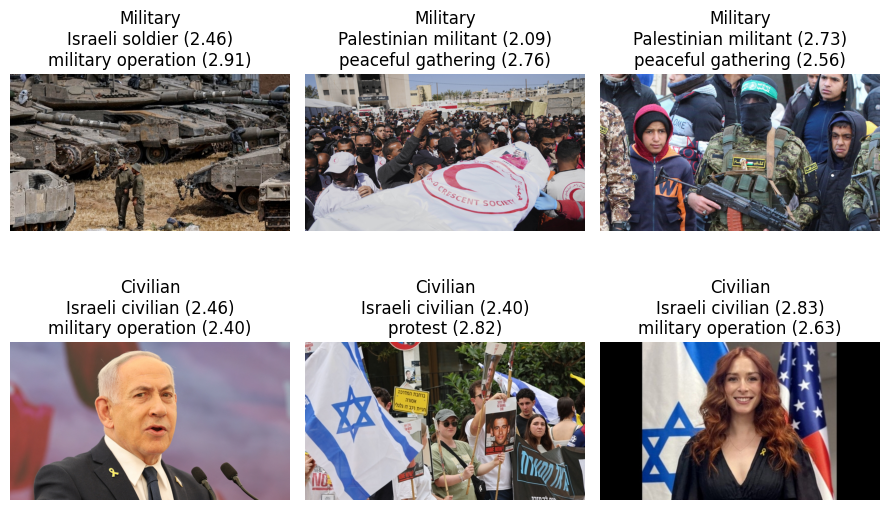

In [82]:
import matplotlib.pyplot as plt
from PIL import Image

military_imgs = df[df["actor"].isin(["Israeli soldier","Palestinian militant"])]
civilian_imgs = df[df["actor"].isin(["Israeli civilian","Palestinian civilian"])]

mil_samples = military_imgs.sample(min(3, len(military_imgs)), random_state=42)
civ_samples = civilian_imgs.sample(min(3, len(civilian_imgs)), random_state=42)

samples = {"Military": mil_samples, "Civilian": civ_samples}

fig, axes = plt.subplots(2, 3, figsize=(9,6))
for row, (label, samp) in enumerate(samples.items()):
    for col, (_, r) in enumerate(samp.iterrows()):
        img = Image.open(r["img_path"]).convert("RGB")  # use img_path now
        axes[row, col].imshow(img)
        axes[row, col].set_title(
            f"{label}\n"
            f"{r['actor']} ({r['actor_score']:.2f})\n"
            f"{r['scene']} ({r['scene_score']:.2f})"
        )
        axes[row, col].axis("off")

# Turn off unused subplots
for unused in range(len(mil_samples), 3):
    axes[0, unused].axis("off")
for unused in range(len(civ_samples), 3):
    axes[1, unused].axis("off")

plt.tight_layout()
plt.show()


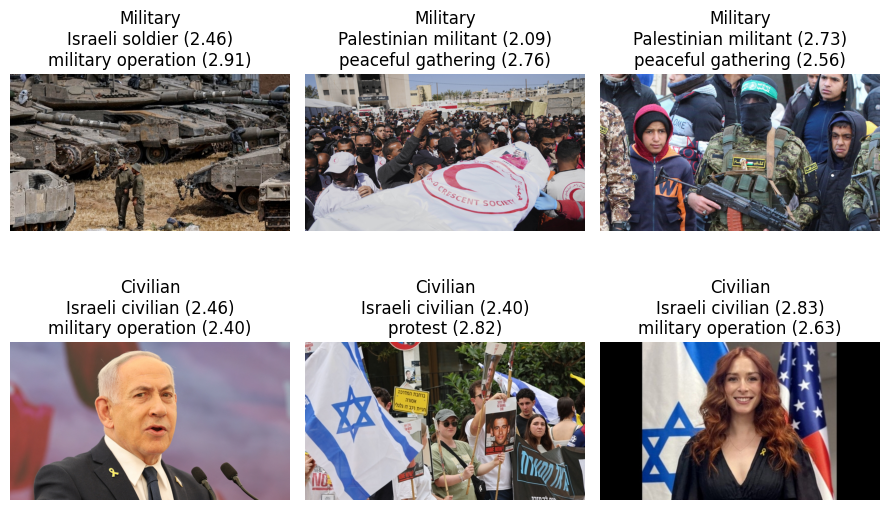

In [83]:
import matplotlib.pyplot as plt
from PIL import Image

military_imgs = df[df["actor"].isin(["Israeli soldier","Palestinian militant"])]
civilian_imgs = df[df["actor"].isin(["Israeli civilian","Palestinian civilian"])]

mil_samples = military_imgs.sample(min(3, len(military_imgs)), random_state=42)
civ_samples = civilian_imgs.sample(min(3, len(civilian_imgs)), random_state=42)

samples = {"Military": mil_samples, "Civilian": civ_samples}

fig, axes = plt.subplots(2, 3, figsize=(9,6))
for row, (label, samp) in enumerate(samples.items()):
    for col, (_, r) in enumerate(samp.iterrows()):
        img = Image.open(r["img_path"]).convert("RGB")  # use img_path now
        axes[row, col].imshow(img)
        axes[row, col].set_title(
            f"{label}\n"
            f"{r['actor']} ({r['actor_score']:.2f})\n"
            f"{r['scene']} ({r['scene_score']:.2f})"
        )
        axes[row, col].axis("off")

# Turn off unused subplots
for unused in range(len(mil_samples), 3):
    axes[0, unused].axis("off")
for unused in range(len(civ_samples), 3):
    axes[1, unused].axis("off")

plt.tight_layout()
plt.show()


In [84]:
print("Hello, world!")

Hello, world!
